<img src="idal-logo.png" align="right" style="float" width="400">
<font color="#CA3532"><h1 align="left">mIA3</h1></font>
<font color="#6E6E6E"><h2 align="left">Trabajo Final de Master: Comparativa de Arquitecturas para Traducción Automática.</h2></font> 

#### Elaborado por Felipe Ramírez Herrera

In [1]:
import warnings
warnings.filterwarnings('ignore')

from enum import Enum
from typing import List
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchtext
import torchtext.data
import torchtext.datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import Vocab
from torch import Tensor

import numpy as np
import time
import pandas as pd
import random
import os
import math
import re
from unicodedata import normalize

from typing import List, Tuple, Union
from collections import Counter 
import pickle

import datetime
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import sentence_bleu




warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)

In [2]:
#!pip install causal-conv1d>=1.4.0
#!pip install mamba-ssm
#!pip install fairseq

# conda remove --name TFM_Env --all
# conda create --name TFM_Env python=3.10
# conda activate TFM_Env
# conda install -n TFM_Env ipykernel --update-deps --force-reinstall
# conda install nvidia::cuda-toolkit (no instalar asi)
# conda install -y pytorch==2.3 torchvision torchaudio torchtext cudatoolkit=12.0 -c pytorch -c nvidia
# conda install -y torchtext -c pytorch
# conda install pytorch::torchtext
# conda install numpy
# conda install scikit-learn
# conda install SpaCy
# conda install matplotlib

In [3]:
import torchtext.vocab as vocab

print(torch.__version__)
print(torchtext.__version__)

2.3.0
0.18.0


### Variables y parámetros globales

In [4]:


# Globales

MIN_ALGO_NUMBER = 1 
MAX_ALGO_NUMBER = 6


DATASET = "OSPC"

NUMBER_OF_EPOCHS = 20
EARLY_STOPPING_EPOCHS = 3
CLIPPING_VALUE = 15 # Limite de crecimiento para los gradientes, usar None para desactivar
MAXIMUM_NUMBER_OF_SAMPLES = 1000000
BATCH_SIZE = 64


GCCN_LR = 0.0001
TFMR_LR = 0.0001

# Nombres de archivos intermedios con preprocesamiento del corpus
pkl_unpc_dataset_file = "un_parallel_corpus.pkl"
pkl_ospc_dataset_file = "os_parallel_corpus.pkl"

en_unpc_vocab_file = 'un_parallel_vocab_en_v2.pth'
es_unpc_vocab_file = 'un_parallel_vocab_es_v2.pth'


en_ospc_vocab_file = 'os_parallel_vocab_en_v2.pth'
es_ospc_vocab_file = 'os_parallel_vocab_es_v2.pth'


# Nombres de archivos con conjuntos de datos para entrenamiento, evaluación e inferencia
unpc_full_data_file = 'un_parallel_full_v2.pth'
unpc_trn_data_file = 'un_parallel_trn_v2.pth'
unpc_val_data_file = 'un_parallel_val_v2.pth'
unpc_tst_data_file = 'un_parallel_tst_v2.pth'

ospc_full_data_file = 'os_parallel_full.pth'
ospc_trn_data_file = 'os_parallel_trn_v2.pth'
ospc_val_data_file = 'os_parallel_val_v2.pth'
ospc_tst_data_file = 'os_parallel_tst_v2.pth'



unpc_ds = None
unpc_en_tokenizer = None
unpc_es_tokenizer = None
unpc_fr_tokenizer = None

ospc_ds = None
ospc_en_tokenizer = None
ospc_es_tokenizer = None
ospc_fr_tokenizer = None

Language = Enum('Language', ['EN', 'ES'])

DatasetScope = Enum('DatasetScope', ['UN', 'OS'])

# Definición de tokens especiales.
PAD_WORD = '<pad>'
UNK_WORD = '<unk>'  # Unknown token symbol
BOS_WORD = '<bos>'  # Begin-of-Sentence token symbol
EOS_WORD = '<eos>'  # End-of-Sentence token symbol

SPECIALS = [PAD_WORD, BOS_WORD, EOS_WORD,  UNK_WORD]

# Constante para convertir de bytes a megabytes
size_to_MB = 1024 * 1024

# Constantes para definir el rango de tamaños de oración preprocesados desde el corpus:
MINIMUM_ALLOWED_SIZE_OF_SEQ = 5
MAXIMUM_ALLOWED_SIZE_OF_SEQ = 450

# Tiempos de espera para descansar el GPU (ante eventuales sobrecalentamientos)
INNER_GPU_REST_TIME = 0 # Rest time between epochs
OUTER_GPU_REST_TIME = 0 # Rest time between model training / validation processes

# Tokens que representan constantes en los diferentes conjuntos de oraciones

UNPC_PAD_EN_IDX = 0
UNPC_BOS_EN_IDX = 0
UNPC_EOS_EN_IDX = 0
UNPC_UNK_EN_IDX = 0

UNPC_PAD_ES_IDX = 0
UNPC_BOS_ES_IDX = 0
UNPC_EOS_ES_IDX = 0
UNPC_UNK_ES_IDX = 0


OSPC_PAD_EN_IDX = 0
OSPC_BOS_EN_IDX = 0
OSPC_EOS_EN_IDX = 0
OSPC_UNK_EN_IDX = 0

OSPC_PAD_ES_IDX = 0
OSPC_BOS_ES_IDX = 0
OSPC_EOS_ES_IDX = 0
OSPC_UNK_ES_IDX = 0


# Variables que contienen los máximo y mínimo valores de la longitud de secuencia (hyperparam)
# unpc_max_seq_length = 64 # Re-calculated further 
# unpc_min_seq_length = 16 # Re-calculated further 


# ospc_max_seq_length = 64 # Re-calculated further 
# ospc_min_seq_length = 16 # Re-calculated further 

# Conjuntos de datos tokenizados
unpc_full_data = []
ospc_full_data = []

trn_unpc_subset = []
val_unpc_subset = []
tst_unpc_subset = []

trn_ospc_subset = []
val_ospc_subset = []
tst_ospc_subset = []

# Tamaño de particiones de los datos
unpc_size_of_trn_set_size = 0
unpc_size_of_val_set_size = 0
unpc_size_of_tst_set_size = 0 

ospc_size_of_trn_set_size = 0
ospc_size_of_val_set_size = 0
ospc_size_of_tst_set_size = 0 

unpc_en_vocabulary = None
unpc_es_vocabulary = None

ospc_en_vocabulary = None
ospc_es_vocabulary = None

# Tamaño de vocabularios (hyperparam)
unpc_en_vocab_size = 0
unpc_es_vocab_size = 0

ospc_en_vocab_size = 0
ospc_es_vocab_size = 0



batches_for_training = 0
batches_for_validation  = 0

# Patrones de checkpoits para modelos:

vanilla_unpc_en_es_model_path = 'TFM_model_unpc_en_es_vanilla_{0}_v2.pth'
vanilla_ospc_en_es_model_path = 'TFM_model_ospc_en_es_vanilla_{0}_v2.pth'

universal_unpc_en_es_model_path = 'TFM_model_unpc_en_es_universal_{0}_v2.pth'
universal_ospc_en_es_model_path = 'TFM_model_ospc_en_es_universal_{0}_v2.pth'

xltsm_unpc_en_es_model_path = 'TFM_model_unpc_en_es_xlstm_{0}_v2.pth'
xltsm_ospc_en_es_model_path = 'TFM_model_ospc_en_es_xlstm_{0}_v2.pth'


jamba_unpc_en_es_model_path = 'TFM_model_unpc_en_es_jamba_{0}_v2.pth'
jamba_ospc_en_es_model_path = 'TFM_model_ospc_en_es_jamba_{0}_v2.pth'

moe_unpc_en_es_model_path = 'TFM_model_unpc_en_es_moe_{0}_v2.pth'
moe_ospc_en_es_model_path = 'TFM_model_ospc_en_es_moe_{0}_v2.pth'

gss_unpc_en_es_model_path = 'TFM_model_unpc_en_es_gss_{0}_v2.pth'
gss_ospc_en_es_model_path = 'TFM_model_ospc_en_es_gss_{0}_v2.pth'

mega_unpc_en_es_model_path = 'TFM_model_unpc_en_es_mega_{0}_v2.pth'
mega_ospc_en_es_model_path = 'TFM_model_ospc_en_es_mega_{0}_v2.pth'

mamba_unpc_en_es_model_path = 'TFM_model_unpc_en_es_s5_{0}_v2.pth'
mamba_ospc_en_es_model_path = 'TFM_model_ospc_en_es_s5_{0}_v2.pth'

linformer_unpc_en_es_model_path = 'TFM_model_unpc_en_es_linfrmr_{0}.pth'
linformer_ospc_en_es_model_path = 'TFM_model_ospc_en_es_linfrmr_{0}_v2.pth'


sinkhorn_unpc_en_es_model_path = 'TFM_model_unpc_en_es_sinkhorn_{0}_v2.pth'
sinkhorn_ospc_en_es_model_path = 'TFM_model_ospc_en_es_sinkhorn_{0}_v2.pth'


reformer_unpc_en_es_model_path = 'TFM_model_unpc_en_es_reformer_{0}_v2.pth'
reformer_ospc_en_es_model_path = 'TFM_model_ospc_en_es_reformer_{0}_v2.pth'

evolved_unpc_en_es_model_path = 'TFM_model_unpc_en_es_evolved_{0}_v2.pth'
evolved_ospc_en_es_model_path = 'TFM_model_ospc_en_es_evolved_{0}_v2.pth'


model_ht = 'model_output_{0}_hist_v2.csv'
model_lp = 'model_output_{0}_lp_v2.csv'
model_fp = 'model_output_{0}_FP_v2.csv'
model_inference = 'model_output_{0}_inference_v2.csv'
model_samples = 'model_output_{0}_samples_v2.csv'






### Preprocesamiento de datos de texto

In [5]:
# https://conferences.unite.un.org/UNCorpus/Home/DownloadOverview
# !cat /home/framirez/translation_multilingual/UNv1.0.6way.tar.gz.* | tar -xzf -

In [6]:
# import zipfile

# EN_corpus_file = "UNv1.0.6way_en.zip" # UN Parallel Corpus English (EN)
# ES_corpus_file = "UNv1.0.6way_es.zip" # UN Parallel Corpus Spanish (ES)

# corpus_source_folder = "/content/drive/MyDrive/"
# corpus_target_folder = "/tmp/"

# if (not os.path.exists(corpus_target_folder + EN_corpus_file)):
#   with zipfile.ZipFile(corpus_source_folder + EN_corpus_file,"r") as zip_ref:
#       zip_ref.extractall(corpus_target_folder)

# if (not os.path.exists(corpus_target_folder + ES_corpus_file)):
#   with zipfile.ZipFile(corpus_source_folder + ES_corpus_file,"r") as zip_ref:
#       zip_ref.extractall(corpus_target_folder)



In [7]:
# https://opus.nlpl.eu/OpenSubtitles/corpus/version/OpenSubtitles

In [8]:
# import gzip
# import shutil

# EN_src_corpus_file = "en.txt.gz" # Open Subtitles 2018 Parallel Corpus English (EN)
# ES_src_corpus_file = "es.txt.gz" # Open Subtitles 2018 Parallel Corpus Spanish (ES)

# EN_tgt_corpus_file = "en.txt" # Open Subtitles 2018 Parallel Corpus English (EN)
# ES_tgt_corpus_file = "es.txt" # Open Subtitles 2018 Parallel Corpus Spanish (ES)

# corpus_source_folder = "/home/framirez/mnt/"
# corpus_target_folder = "/home/framirez/mnt/"

# if (not os.path.exists(corpus_target_folder + EN_tgt_corpus_file)):
#   with gzip.open(corpus_source_folder + EN_src_corpus_file, 'rb') as f_in, open(corpus_source_folder + EN_tgt_corpus_file, 'wb') as f_out:
#     shutil.copyfileobj(f_in, f_out)

# if (not os.path.exists(corpus_target_folder + ES_tgt_corpus_file)):
#   with gzip.open(corpus_source_folder + ES_src_corpus_file, 'rb') as f_in, open(corpus_source_folder + ES_tgt_corpus_file, 'wb') as f_out:
#     shutil.copyfileobj(f_in, f_out)


In [9]:
# Tomado de https://github.com/KristinaRay/english-arabic-nmt-bot/blob/main/data/preprocessing.py

import re

def replace_contractions(sentence: str) -> str:
    """
    reference
    https://www.enchantedlearning.com/grammar/contractions/list.shtml
    https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
    """
    contractions_dict = {
                      "'cause": "because",
                      "'em": "them",
                      "'tis": "it is",
                      "'twas": "it was",
                      "I'd": "I would",
                      "I'd've": "I would have",
                      "I'll": "I will",
                      "I'll've": "I will have",
                      "I'm": "I am",
                      "I'm'a": "I am about to",
                      "I'm'o": "I am going to",
                      "I've": "I have",
                      "Whatcha": "What are you",
                      "ain't": "are not",
                      "amn't": "am not",
                      "aren't": "are not",
                      "can't": "cannot",
                      "could've": "could have",
                      "couldn't": "could not",
                      "daren't": "dare not",
                      "daresn't": "dare not",
                      "dasn't": "dare not",
                      "didn't": "did not",
                      "doesn't": "does not",
                      "don't": "do not",
                      "everyone's": "everyone is",
                      "finna": "fixing to",
                      "gimme": "give me",
                      "gon't": "go not",
                      "gonna": "going to",
                      "gotta": "got to",
                      "hadn't": "had not",
                      "hasn't": "has not",
                      "haven't": "have not",
                      "he'd": "he had",
                      "he'll": "he will",
                      "he's": "he is",
                      "here's": "here is",
                      "how'd": "how did",
                      "how'd'y": "how do you",
                      "how'll": "how will",
                      "how're": "how are",
                      "how's": "how is",
                      "i'd": "i would",
                      "i'd've": "i would have",
                      "i'll": "i will",
                      "i'll've": "i will have",
                      "i'm": "i am",
                      "i've": "i have",
                      "isn't": "is not",
                      "it'd": "it would",
                      "it'd've": "it would have",
                      "it'll": "it will",
                      "it'll've": "it will have",
                      "it's": "it is",
                      "kinda": "kind of",
                      "let's": "let us",
                      "luv": "love",
                      "ma'am": "madam",
                      "may've": "may have",
                      "mayn't": "may not",
                      "might've": "might have",
                      "mightn't": "might not",
                      "mightn't've": "might not have",
                      "must've": "must have",
                      "mustn't": "must not",
                      "mustn't've": "must not have",
                      "ne'er": "never",
                      "needn't": "need not",
                      "needn't've": "need not have",
                      "o'": "of",
                      "o'clock": "of the clock",
                      "ol'": "old",
                      "oughtn't": "ought not",
                      "oughtn't've": "ought not have",
                      "sha'n't": "shall not",
                      "shan't": "shall not",
                      "shan't've": "shall not have",
                      "she'd": "she had",
                      "she'd've": "she would have",
                      "she'll": "she will",
                      "she'll've": "she will have",
                      "she's": "she is",
                      "should've": "should have",
                      "shouldn't": "should not",
                      "shouldn't've": "should not have",
                      "so's": "so is",
                      "so've": "so have",
                      "somebody's": "somebody is",
                      "someone's": "someone is",
                      "something's": "something is",
                      "that'd've": "that would have",
                      "that'll": "that will",
                      "that's": "that is",
                      "there'd": "there would",
                      "there'd've": "there would have",
                      "there'll": "there will",
                      "there're": "there are",
                      "there's": "there is",
                      "these're": "these are",
                      "they'd": "they would",
                      "they'd've": "they would have",
                      "they'll": "they will",
                      "they'll've": "they will have",
                      "they're": "they are",
                      "they've": "they have",
                      "those're": "those are",
                      "to've": "to have",
                      "wanna": "want to",
                      "wasn't": "was not",
                      "we'd": "we would",
                      "we'd've": "we would have",
                      "we'll": "we will",
                      "we'll've": "we will have",
                      "we're": "we are",
                      "we've": "we have",
                      "weren't": "were not",
                      "what'd": "what would",
                      "what'll": "what will",
                      "what'll've": "what will have",
                      "what're": "what are",
                      "what's": "what is",
                      "what've": "what have",
                      "when'd": "when would",
                      "when'll": "when will",
                      "when's": "when is",
                      "when've": "when have",
                      "where'd": "where would",
                      "where'll": "where will",
                      "where's": "where is",
                      "which's": "which is",
                      "who'd": "who would",
                      "who'd've": "who would have",
                      "who'll": "who will",
                      "who'll've": "who will have",
                      "who're": "who are",
                      "who's": "who is",
                      "why'd": "why would",
                      "why'll": "why will",
                      "why're": "why are",
                      "why's": "why is",
                      "why've": "why have",
                      "will've": "will have",
                      "won't": "will not",
                      "won't've": "will not have",
                      "would've": "would have",
                      "wouldn't": "would not",
                      "wouldn't've": "would not have",
                      "y'all": "you all",
                      "y'all'd": "you all would",
                      "y'all'd've": "you all would have",
                      "y'all're": "you all are",
                      "y'all've": "you all have",
                      "you'd": "you would",
                      "you'd've": "you would have",
                      "you'll": "you will",
                      "you'll've": "you will have",
                      "you're": "you are",
                      "you've": "you have"                
    }
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)] 
    return contractions_re.sub(replace, sentence)
    
def replace_misspell(sentence: str) -> str:
    """
    reference
    https://www.macmillandictionary.com/misspells.html
    """
    mispell_dict = {
                  'colour': 'color',
                  'centre': 'center',
                  'favourite': 'favorite', 
                  'travelling': 'traveling', 
                  'counselling': 'counseling',
                  'theatre': 'theater', 
                  'cancelled': 'canceled', 
                  'labour': 'labor', 
                  'organisation': 'organization', 
                  'wwii': 'world war 2',
                  'citicise': 'criticize', 
                  'youtu ': 'youtube ', 
                  'Qoura': 'Quora', 
                  'sallary': 'salary', 
                  'Whta': 'What', 
                  'narcisist': 'narcissist', 
                  'howdo': 'how do', 
                  'whatare': 'what are', 
                  'howcan': 'how can', 
                  'howmuch': 'how much', 
                  'howmany': 'how many', 
                  'whydo': 'why do', 
                  'doI': 'do I', 
                  'theBest': 'the best', 
                  'howdoes': 'how does', 
                  'Etherium': 'Ethereum', 
                  'narcissit': 'narcissist', 
                  'bigdata': 'big data', 
                  '2k17': '2017', 
                  '2k18': '2018', 
                  'qouta': 'quota', 
                  'exboyfriend': 'ex boyfriend', 
                  'airhostess': 'air hostess',
                  'whst': 'what', 
                  'watsapp': 'whatsapp',
                  'demonitisation': 'demonetization',
                  'demonitization': 'demonetization',
                  'demonetisation': 'demonetization',
                  'accomodation': 'accommodation',
                  'adress': 'address',
                  'accomodate': 'accommodate',
                  'wether': 'weather', # whether 
                  'rehersal': 'rehearsal',
                  'commited': 'committed',
                  'persue': 'pursue',
                  'occurence': 'occurrence',
                  'lenght': 'length',
                  'strenght': 'strength',
                  'seperate': 'separate',
                  'appaling': 'appalling',
                  'tought': 'thought', # taught
                  'throught': 'through',
                  'commision': 'commission',
                  'comission': 'commission',
                  'recieve': 'receive', 
                  'collegue': 'colleague',
                  'desease': 'disease',
                  'compell': 'compel',
                  'bizzare': 'bizarre',
                  'concious': 'conscious',
                  'advertisment': 'advertisement',
                  'succint': 'succinct',
                  'rythm': 'rhythm',
                  'wich': 'which', # witch
                  'wheather': 'weather', # whether 
                  'percieve': 'perceive',
                  'occure': 'occur',
                  'enterpreneur': 'entrepreneur',
                  'aquire': 'acquire',
                  'convinient': 'convenient',
                  'devide': 'divide',
                  'agressive': 'aggressive',
                  'enviroment': 'environment',
                  'supress': 'suppress',
                  'embarassed': 'embarrassed',
                  'miniscule':'minuscule',
                  'occured': 'occurred',
                  'strech': 'stretch',
                  'embarrased': 'embarrassed',
                  'responsability': 'responsibility',
                  'assesment': 'assessment',
                  'akward': 'awkward',
                  'endevour': 'endeavour',
                  'belive': 'believe',
                  'wierd ': 'weird',
                  'achive': 'achieve',
                  'greatful': 'grateful',
                  'biogrophay':'biography'
    }

    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    def replace(match):
        return mispell_dict[match.group(0)] 
    return mispell_re.sub(replace, sentence)

def replace_endings(sentence: str) -> str:
    """
    reference
    https://github.com/kootenpv/contractions/blob/master/contractions/data/leftovers_dict.json
    """
    endings_dict = {
                  "'all": " all",
                  "'am": " am",
                  "'cause": "because",
                  "'d": " would",
                  "'ll": " will",
                  "'re": " are",
                  "'em": "them",
                  "'er": " her",
                  "doin'": "doing",
                  "goin'": "going",
                  "nothin'": "nothing",
                  "somethin'": "something",
                  "havin'": "having",
                  "lovin'": "loving",
                  "'coz": "because",
                  "thats": "that is",
                  "whats": "what is"
    }
    endings_re = re.compile('(%s)' % '|'.join(endings_dict.keys()))
    def replace(match):
        return endings_dict[match.group(0)] 
    return endings_re.sub(replace, sentence)

def replace_slang(sentence: str) -> str:
    """
    reference
    https://github.com/kootenpv/contractions/blob/master/contractions/data/slang_dict.json
    """
    slang_dict = {
                "'aight": "alright",
                "dunno": "do not know",
                "howdy": "how do you do",
                "ima": "I am going to",
                "innit": "is it not",
                "iunno": "I do not know",
                "g'day": "good day",
                "gonna": "going to",
                "gotta": "got to",
                "wanna": "want to",
                "woulda": "would have",
                "gimme": "give me",
                "asap": "as soon as possible",
                " u ": " you ",
                " r ": " are "
    }
    slang_re = re.compile('(%s)' % '|'.join(slang_dict.keys()))
    def replace(match):
        return slang_dict[match.group(0)] 
    return slang_re.sub(replace, sentence)


def preprocess_sentence(sentence: str) -> str:
    '''
    Lowercase, trim, and remove non-letter and non-digit characters
    ''' 
    sentence = sentence.lower()
    clean = lambda x: x in  "abcdefghijklmnopqrstuvwxyz '\n"
    sentence = ''.join([i for i in  sentence if  clean(i)])
    sentence = re.sub(' +', ' ', sentence)
    return sentence

def preprocess_clean_ospc_en_text(sentence: str) -> str:
    preprocess = [replace_contractions, replace_misspell, replace_endings, replace_slang, preprocess_sentence]
    for f in preprocess:
        sentence = f(sentence)
    return sentence

In [10]:
def cleanPunc(sentence): 
    """
    Limpia la oración de cualquier signo de puntuación o caracteres especiales.
    
    Parameters:
    sentence (str): Oración que se desea limpiar.
    
    Returns:
    str: Oración limpia sin los caracteres específicos.
    """
    sentence = re.sub(r'<.*?>', '', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = re.sub(r'[^\w\s.,:;?!¿¡-]', '', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence)
    sentence = sentence.strip()
    sentence = sentence.replace("\n", " ")
    return sentence

# Función para limpiar acentos de las letras en el texto de entrada
def cleanAccents(sentence):
    """
    Limpia los acentos de las letras en el texto de entrada.
    
    Parameters:
    sentence (str): Texto que se desea limpiar de acentos.
    
    Returns:
    str: Texto con los acentos removidos.
    """
    return normalize('NFD', sentence)

# Función para producir un texto basado puramente en el alfabeto
def keepAlpha(sentence):
    """
    Produce un texto que consiste únicamente en caracteres alfabéticos.
    
    Parameters:
    sentence (str): Oración que se desea filtrar.
    
    Returns:
    str: Oración que contiene solo caracteres alfabéticos y espacios.
    """
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent



# Función para eliminar un patrón específico de texto
def remove_pattern(input_txt, pattern):
    """
    Elimina un patrón específico de texto utilizando expresiones regulares.
    
    Parameters:
    input_txt (str): Texto del cual se desea eliminar el patrón.
    pattern (str): Patrón de expresión regular que se desea eliminar.
    
    Returns:
    str: Texto sin el patrón especificado.
    """
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

# Función para quitar acentos específicos de letras
def f_remove_accents(x):
    """
    Elimina acentos específicos de letras en el texto.
    
    Parameters:
    x (str): Texto del cual se desean eliminar los acentos específicos.
    
    Returns:
    str: Texto sin los acentos específicos.
    """
    y = re.sub(r'[àáâãäå]', 'a', x)
    y = re.sub(r'[èéêë]', 'e', y)
    y = re.sub(r'[ìíîï]', 'i', y)
    y = re.sub(r'[òóôõö]', 'o', y)
    y = re.sub(r'[ùúûü]', 'u', y)
    return y

# Función para quitar espacios adicionales en el texto
def f_remove_spaces(x):
    """
    Elimina espacios adicionales en el texto.
    
    Parameters:
    x (str): Texto del cual se desean eliminar los espacios adicionales.
    
    Returns:
    str: Texto sin espacios adicionales entre palabras.
    """
    return " ".join(x.split())




def preprocessUN(data, col = 'text_en'):
    data[col] = data[col].str.lower()
    data[col] = data[col].apply(f_remove_accents) # OJO
    data[col] = data[col].apply(f_remove_spaces) # OJO
    data[col] = data[col].apply(cleanPunc)
    data[col] = data[col].apply(keepAlpha)
    return data


def preprocessOS(data, col = 'text_en', english = False):
    if english:
        data[col] = data[col].apply(preprocess_clean_ospc_en_text) 
    data[col] = data[col].str.lower()
    data[col] = data[col].apply(f_remove_accents) # OJO
    data[col] = data[col].apply(f_remove_spaces) # OJO
    data[col] = data[col].apply(cleanPunc)
    data[col] = data[col].apply(keepAlpha)
    return data


In [11]:
# Inicializa varias semillas en diferentes bibliotecas (como random, numpy y torch) para garantizar 
# la reproducibilidad de los resultados al ejecutar código que involucra aleatoriedad.

def seed_everything(seed=1234):
    """
    Establece todas las semillas para garantizar la reproducibilidad.

    Args:
        seed (int, opcional): Número entero para inicializar las semillas. Default es 73.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Algunos métodos de cudnn pueden ser aleatorios incluso después de fijar la semilla, 
    # a menos que se especifique como determinístico
    torch.backends.cudnn.deterministic = True

In [12]:
# Función generadora de los ejemplos a partir de los tres archivos del Corpus en EN/ES/FR
def generate_examples(src_file, tgt_file):
    data = []
    
    with open(src_file, encoding="utf-8") as src_f, open(tgt_file, encoding="utf-8") as tgt_f:
        # i = 0
        for idx, (a, b) in enumerate(zip(src_f, tgt_f)):           
            if (a.isspace() | b.isspace()):
                continue
            data.append({'text_en' : a, 'text_es' : b})
            # i += 1
            # if i > MAXIMUM_NUMBER_OF_SAMPLES: # ELIMINAR ESTA RESTRICCION, HACER MUESTREO ALEATORIO
            #     break

    return pd.DataFrame.from_records(data=data)

conda install -y pytorch==1.9 torchvision torchaudio torchtext cudatoolkit=11.0 -c pytorch -c nvidia

In [13]:
if torch.cuda.is_available():
    !nvidia-smi

Sun May 11 23:19:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:08:00.0  On |                  N/A |
|  0%   56C    P8             18W /  170W |    2144MiB /  12288MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
import torchtext.vocab as tv   
def build_vocab(list):
    vocab = tv.build_vocab_from_iterator(iterator=list, specials=SPECIALS)
    vocab.set_default_index(vocab[UNK_WORD])
    return vocab

In [15]:


# Extrae los tokens de acuerdo al lenguaje de un conjunto (EN, ES)
def yield_tokens_unpc(Lang: Language = Language.EN):
    for index, row in unpc_ds.iterrows():     
         
         if (Lang == Language.EN):
            seq = unpc_en_tokenizer(str(row["text_en"]))  
         
         if (Lang == Language.ES):
            seq = unpc_es_tokenizer(str(row["text_es"]))

         yield seq

# Extrae los tokens de acuerdo al lenguaje de un conjunto (EN, ES) 
def yield_tokens_ospc(Lang: Language = Language.EN):
    for index, row in ospc_ds.iterrows():     
         if (Lang == Language.EN):
            seq = ospc_en_tokenizer(str(row["text_en"]))  
         if (Lang == Language.ES):
            seq = ospc_es_tokenizer(str(row["text_es"]))
         yield seq


In [16]:
# El corpus debe ser el fully aligned de UN Parellel Corpus, se descarga de acá:
# https://conferences.unite.un.org/UNCorpus/Home/DownloadOverview

# Y se descomprime de la siguiente forma:
# cat /home/framirez/translation_multilingual/UNv1.0.6way.tar.gz.* | tar -xzf -

# No se puede automatizar la descarga del corpus por el tipo de enlace (onedrive)

if os.path.exists(pkl_unpc_dataset_file):
    unpc_ds = pd.read_pickle(pkl_unpc_dataset_file) 
else:
    en_train_path = "./mnt/drive/UNv1.0.6way.en"
    es_train_path = "./mnt/drive/UNv1.0.6way.es"
    df = generate_examples(en_train_path, es_train_path)
    preprocessUN(df, 'text_en')
    preprocessUN(df, 'text_es')
    unpc_ds = df
    unpc_ds.to_pickle(pkl_unpc_dataset_file)


unpc_ds_full_size = len(unpc_ds)

print("UN Dataset Size = {0}".format(unpc_ds_full_size))


# Se acota el conjunto de datos a una fracción manejable en el hardware
unpc_ds = unpc_ds.head(MAXIMUM_NUMBER_OF_SAMPLES)

# Se utilizan los tokenizadores de SpAcy

# !python -m spacy download en_core_web_sm
# !python -m spacy download es_core_news_sm

unpc_en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
unpc_es_tokenizer = get_tokenizer('spacy', language='es_core_news_sm')


# Carga o genera el vocabulario en EN    
if os.path.exists(en_unpc_vocab_file):
    unpc_en_vocabulary = torch.load(en_unpc_vocab_file)
else:
    unpc_en_vocabulary = build_vocab(yield_tokens_unpc(Language.EN))
    torch.save(unpc_en_vocabulary, en_unpc_vocab_file)

# Carga o genera el vocabulario en ES
if os.path.exists(es_unpc_vocab_file):
    unpc_es_vocabulary = torch.load(es_unpc_vocab_file)
else:
    unpc_es_vocabulary = build_vocab(yield_tokens_unpc(Language.ES))
    torch.save(unpc_es_vocabulary, es_unpc_vocab_file)


# Asigna símbolos especiales con respecto al vocabulario EN
UNPC_PAD_EN_IDX = unpc_en_vocabulary[PAD_WORD]
UNPC_BOS_EN_IDX = unpc_en_vocabulary[BOS_WORD]
UNPC_EOS_EN_IDX = unpc_en_vocabulary[EOS_WORD]
UNPC_UNK_EN_IDX = unpc_en_vocabulary[UNK_WORD]

# Asigna símbolos especiales con respecto al vocabulario ES
UNPC_PAD_ES_IDX = unpc_es_vocabulary[PAD_WORD]
UNPC_BOS_ES_IDX = unpc_es_vocabulary[BOS_WORD]
UNPC_EOS_ES_IDX = unpc_es_vocabulary[EOS_WORD]
UNPC_UNK_ES_IDX = unpc_es_vocabulary[UNK_WORD]


# Se determinan los tamaños de los vocabularios (hiperparametros)
unpc_en_vocab_size = len(unpc_en_vocabulary) 
unpc_es_vocab_size = len(unpc_es_vocabulary) 


# Se despliegan los valores de los tamaños de los vocabularios
print("UNPC EN Vocabulary Size = {0}".format(unpc_en_vocab_size))
print("UNPC ES Vocabulary Size = {0}".format(unpc_es_vocab_size))


# Se imprime los caracteres especiales
print("UNPC EN: PAD = {0} BOS = {1} EOS = {2} UNK = {3}".format(UNPC_PAD_EN_IDX, UNPC_BOS_EN_IDX, UNPC_EOS_EN_IDX, UNPC_UNK_EN_IDX))
print("UNPC ES: PAD = {0} BOS = {1} EOS = {2} UNK = {3}".format(UNPC_PAD_ES_IDX, UNPC_BOS_ES_IDX, UNPC_EOS_ES_IDX, UNPC_UNK_ES_IDX))

display (unpc_ds.head(10))



UN Dataset Size = 11365709
UNPC EN Vocabulary Size = 93097
UNPC ES Vocabulary Size = 122153
UNPC EN: PAD = 0 BOS = 1 EOS = 2 UNK = 3
UNPC ES: PAD = 0 BOS = 1 EOS = 2 UNK = 3


,text_en,text_es
0,resolution,resolucion
1,adopted by the security council at its th mee...,aprobada por el consejo de seguridad en su s...
2,the security council,el consejo de seguridad
3,reaffirming all its previous resolutions on th...,reafirmando todas sus resoluciones anteriores ...
4,recalling the statements made by the president...,recordando las declaraciones formuladas por el...
5,having considered the report of the secretary ...,habiendo examinado el informe del secretario g...
6,reaffirming its resolution of september ...,reafirmando su resolucion de de septiemb...
7,strongly condemning the ongoing violence in rw...,condenando energicamente la violencia actual e...
8,stressing the importance of the arusha peace a...,subrayando la importancia del acuerdo de paz d...
9,commending the efforts of the organization of ...,encomiando las gestiones realizadas por la org...


In [17]:
# El corpus debe ser el fully aligned de OpenSubtitles 2018, se descarga de acá:
# https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-es.txt.zip


if os.path.exists(pkl_ospc_dataset_file):
    ospc_ds = pd.read_pickle(pkl_ospc_dataset_file) 
else:
    en_train_path = "./mnt/OpenSubtitles.en-es.en"
    es_train_path = "./mnt/OpenSubtitles.en-es.es"
    df = generate_examples(en_train_path, es_train_path)
    preprocessOS(df, 'text_en', True)
    preprocessOS(df, 'text_es', False)
    ospc_ds = df
    ospc_ds.to_pickle(pkl_ospc_dataset_file)


ospc_ds_full_size = len(ospc_ds)

print("OS Dataset Size = {0}".format(ospc_ds_full_size))

# Se acota el conjunto de datos a una fracción manejable en el hardware
ospc_ds = ospc_ds.head(MAXIMUM_NUMBER_OF_SAMPLES)

# Se utilizan los tokenizadores de SpAcy

# !python -m spacy download en_core_web_sm
# !python -m spacy download es_core_news_sm

ospc_en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
ospc_es_tokenizer = get_tokenizer('spacy', language='es_core_news_sm')


# Carga o genera el vocabulario en EN    
if os.path.exists(en_ospc_vocab_file):
    ospc_en_vocabulary = torch.load(en_ospc_vocab_file)
else:
    ospc_en_vocabulary = build_vocab(yield_tokens_ospc(Language.EN))
    torch.save(ospc_en_vocabulary, en_ospc_vocab_file)

# Carga o genera el vocabulario en ES
if os.path.exists(es_ospc_vocab_file):
    ospc_es_vocabulary = torch.load(es_ospc_vocab_file)
else:
    ospc_es_vocabulary = build_vocab(yield_tokens_ospc(Language.ES))
    torch.save(ospc_es_vocabulary, es_ospc_vocab_file)


# Asigna símbolos especiales con respecto al vocabulario EN
OSPC_PAD_EN_IDX = ospc_en_vocabulary[PAD_WORD]
OSPC_BOS_EN_IDX = ospc_en_vocabulary[BOS_WORD]
OSPC_EOS_EN_IDX = ospc_en_vocabulary[EOS_WORD]
OSPC_UNK_EN_IDX = ospc_en_vocabulary[UNK_WORD]

# Asigna símbolos especiales con respecto al vocabulario ES
OSPC_PAD_ES_IDX = ospc_es_vocabulary[PAD_WORD]
OSPC_BOS_ES_IDX = ospc_es_vocabulary[BOS_WORD]
OSPC_EOS_ES_IDX = ospc_es_vocabulary[EOS_WORD]
OSPC_UNK_ES_IDX = ospc_es_vocabulary[UNK_WORD]


# Se determinan los tamaños de los vocabularios (hiperparametros)
ospc_en_vocab_size = len(ospc_en_vocabulary) 
ospc_es_vocab_size = len(ospc_es_vocabulary) 


# Se despliegan los valores de los tamaños de los vocabularios
print("OSPC EN Vocabulary Size = {0}".format(ospc_en_vocab_size))
print("OSPC ES Vocabulary Size = {0}".format(ospc_es_vocab_size))


# Se imprime los caracteres especiales
print("OSPC EN: PAD = {0} BOS = {1} EOS = {2} UNK = {3}".format(OSPC_PAD_EN_IDX, OSPC_BOS_EN_IDX, OSPC_EOS_EN_IDX, OSPC_UNK_EN_IDX))
print("OSPC ES: PAD = {0} BOS = {1} EOS = {2} UNK = {3}".format(OSPC_PAD_ES_IDX, OSPC_BOS_ES_IDX, OSPC_EOS_ES_IDX, OSPC_UNK_ES_IDX))

display (ospc_ds.head())



OS Dataset Size = 61434251
OSPC EN Vocabulary Size = 70729
OSPC ES Vocabulary Size = 94982
OSPC EN: PAD = 0 BOS = 1 EOS = 2 UNK = 3
OSPC ES: PAD = 0 BOS = 1 EOS = 2 UNK = 3


,text_en,text_es
0,the loner,la solitaria
1,you love curry right,te encanta el curry no
2,i will give you more,te pondre mas
3,hey,eh
4,is it good,esta bueno


In [18]:
mask = ospc_ds['text_en'].str.len() > 200 
ospc_ds_large = ospc_ds.loc[mask]

display (ospc_ds_large.head(10))

,text_en,text_es
3562,they are on a fiveday shootout a photographic ...,estan en una exploracion fotografica de cinco ...
3575,fuelled by existential restlessness baby boome...,impulsados por la inquietud existencial la pas...
3585,around the same time the bisson brothers emplo...,mas o menos por la misma epoca los hermanos bi...
3587,they say that timothy osullivan was a master a...,dicen que timothy osullivan era un maestro de ...
3617,he does not give a damn if the verticals are s...,le importaba un comino si las verticales estab...
3708,i did not really dig the french photography yo...,a mi en verdad no me gustaba la fotografia fra...
3754,at that time i was interested in capturing an ...,en ese tiempo yo estaba interesado en capturar...
3758,for example this is a catch picture walking on...,por ejemplo esta es un imagen capturada camina...
3803,he was always obsessed when i first met garry ...,la primera vez que me encontre con garry que y...
3862,but left to its own devices the camera can be ...,pero dejada a su suerte la camara puede no ser...


In [19]:
un_max_len = 0                             # Inicializa la longitud máxima como 0
un_min_len = 10000                         # Inicializa la longitud mínima como un número grande para asegurar que se actualizará correctamente

# Itera a través de los valores del DataFrame consolidado
for smp, s in unpc_ds.values: 
    # Llama a la función es_tokenizer para obtener los tokens
    tokens_x = unpc_es_tokenizer(smp)  
    tokens_y = unpc_en_tokenizer(s)  
    # Calcula la longitud de la lista de tokens
    l_of_x = len(tokens_x)
    l_of_y = len(tokens_y)
    # Actualiza max_len si la longitud actual es mayor
    un_max_len = max(un_max_len, l_of_x, l_of_y)
    # Actualiza min_len si la longitud actual es menor
    un_min_len = min(un_min_len, l_of_x, l_of_y)

# Imprime las longitudes máxima y mínima encontradas
print("UN max_len = {0}".format(un_max_len))
print("UN min_len = {0}".format(un_min_len))

# Calcula MAX_LEN como la longitud máxima encontrada más 2
UN_MAX_LEN =  un_max_len + 2 # suma BOS y EOS

UN max_len = 941
UN min_len = 0


In [20]:
os_max_len = 0                             # Inicializa la longitud máxima como 0
os_min_len = 10000                         # Inicializa la longitud mínima como un número grande para asegurar que se actualizará correctamente

# Itera a través de los valores del DataFrame consolidado
for smp, s in ospc_ds.values: 
    # Llama a la función es_tokenizer para obtener los tokens
    tokens_x = ospc_es_tokenizer(smp)  
    tokens_y = ospc_en_tokenizer(s)  
    # Calcula la longitud de la lista de tokens
    l_of_x = len(tokens_x)
    l_of_y = len(tokens_y)
    # Actualiza max_len si la longitud actual es mayor
    os_max_len = max(os_max_len, l_of_x, l_of_y)
    # Actualiza min_len si la longitud actual es menor
    os_min_len = min(os_min_len, l_of_x, l_of_y)

# Imprime las longitudes máxima y mínima encontradas
print("OS max_len = {0}".format(os_max_len))
print("OS min_len = {0}".format(os_min_len))

# Calcula MAX_LEN como la longitud máxima encontrada más 2
OS_MAX_LEN = os_max_len + 2 # suma BOS y EOS

OS max_len = 103
OS min_len = 0


In [21]:
# Esta función toma un texto y lo convierte en una secuencia de tokens representados como tensores en el dispositivo 
# especificado (device). Devuelve dos tensores: token_seq, que es la secuencia de tokens, y token_cnt, que es la cantidad 
# de tokens en esa secuencia.

def unpc_tensor_transform_en(text, device):   
    """
    Convierte un texto en una secuencia de tokens representados como tensores en el dispositivo especificado.

    Args:
    - text (str): Texto que se va a convertir en tokens.
    - device (torch.device): Dispositivo en el que se almacenarán los tensores (CPU o GPU).

    Returns:
    - token_seq (torch.Tensor): Tensor que contiene la secuencia de tokens como tensores.
    - token_cnt (torch.Tensor): Tensor que contiene la cantidad de tokens en la secuencia.
    """                      
    token_ids = [torch.tensor(unpc_en_vocabulary[token], device=device) for token in unpc_en_tokenizer(text)] 
    token_cnt = len(token_ids)

    if token_cnt > MAXIMUM_ALLOWED_SIZE_OF_SEQ:
        return None, 0

    token_ids = [torch.tensor(UNPC_BOS_ES_IDX, device=device)] + token_ids + [torch.tensor(UNPC_EOS_ES_IDX, device=device)]
    token_seq = torch.as_tensor(token_ids, device = device)
    token_cnt = torch.as_tensor(token_cnt, device = device)
    return token_seq, token_cnt


def unpc_tensor_transform_es(text, device):   
    """
    Convierte un texto en una secuencia de tokens representados como tensores en el dispositivo especificado.

    Args:
    - text (str): Texto que se va a convertir en tokens.
    - device (torch.device): Dispositivo en el que se almacenarán los tensores (CPU o GPU).

    Returns:
    - token_seq (torch.Tensor): Tensor que contiene la secuencia de tokens como tensores.
    - token_cnt (torch.Tensor): Tensor que contiene la cantidad de tokens en la secuencia.
    """                      
    token_ids = [torch.tensor(unpc_es_vocabulary[token], device=device) for token in unpc_es_tokenizer(text)] 
    token_cnt = len(token_ids)

    if token_cnt > MAXIMUM_ALLOWED_SIZE_OF_SEQ:
        return None, 0

    token_ids = [torch.tensor(UNPC_BOS_ES_IDX, device=device)] + token_ids + [torch.tensor(UNPC_EOS_ES_IDX, device=device)]
    token_seq = torch.as_tensor(token_ids, device = device)
    token_cnt = torch.as_tensor(token_cnt, device = device)
    return token_seq, token_cnt

# Esta clase implementa un Dataset de PyTorch para manejar tweets y sus etiquetas asociadas. Los tweets y las etiquetas 
# se pasan como listas, junto con la longitud máxima permitida para los tokens y el dispositivo en el que se almacenarán 
# los tensores. Los métodos __len__ y __getitem__ son implementados para permitir el acceso a los elementos del conjunto
#  de datos.

class UNParallelCorpus(Dataset):
    def __init__(self, text_en, text_es, index, max_len, device):

        self.text_en = text_en
        self.text_es = text_es
        self.index = index
        self.max_len = max_len
        self.device = device
        
    def __len__(self):
        """
        Devuelve la cantidad de tweets en el conjunto de datos.

        Returns:
        - int: Número total de tweets en el conjunto de datos.
        """
        return len(self.text_en)

    def __getitem__(self, item):
        """
        Obtiene un elemento del conjunto de datos en forma de diccionario con los tweets, tokens, etiquetas y longitudes.

        Args:
        - item (int): Índice del elemento a obtener.

        Returns:
        - dict: Diccionario con claves 'texts', 'inputs', 'labels' y 'lengths'.
        """
        src = self.text_en[item]
        tgt = self.text_es[item]
        idx = self.index[item]
        return {
            'src': src,
            'tgt': tgt,
            'idx':idx
        }

In [22]:
# Esta función toma un texto y lo convierte en una secuencia de tokens representados como tensores en el dispositivo 
# especificado (device). Devuelve dos tensores: token_seq, que es la secuencia de tokens, y token_cnt, que es la cantidad 
# de tokens en esa secuencia.

def ospc_tensor_transform_en(text, device):   
    """
    Convierte un texto en una secuencia de tokens representados como tensores en el dispositivo especificado.

    Args:
    - text (str): Texto que se va a convertir en tokens.
    - device (torch.device): Dispositivo en el que se almacenarán los tensores (CPU o GPU).

    Returns:
    - token_seq (torch.Tensor): Tensor que contiene la secuencia de tokens como tensores.
    - token_cnt (torch.Tensor): Tensor que contiene la cantidad de tokens en la secuencia.
    """                      
    token_ids = [torch.tensor(ospc_en_vocabulary[token], device=device) for token in ospc_en_tokenizer(text)] 
    token_cnt = len(token_ids)

    if token_cnt > MAXIMUM_ALLOWED_SIZE_OF_SEQ:
        return None, 0

    token_ids = [torch.tensor(OSPC_BOS_ES_IDX, device=device)] + token_ids + [torch.tensor(OSPC_EOS_ES_IDX, device=device)]
    token_seq = torch.as_tensor(token_ids, device = device)
    token_cnt = torch.as_tensor(token_cnt, device = device)
    return token_seq, token_cnt


def ospc_tensor_transform_es(text, device):   
    """
    Convierte un texto en una secuencia de tokens representados como tensores en el dispositivo especificado.

    Args:
    - text (str): Texto que se va a convertir en tokens.
    - device (torch.device): Dispositivo en el que se almacenarán los tensores (CPU o GPU).

    Returns:
    - token_seq (torch.Tensor): Tensor que contiene la secuencia de tokens como tensores.
    - token_cnt (torch.Tensor): Tensor que contiene la cantidad de tokens en la secuencia.
    """                      
    token_ids = [torch.tensor(ospc_es_vocabulary[token], device=device) for token in ospc_es_tokenizer(text)] 
    token_cnt = len(token_ids)

    if token_cnt > MAXIMUM_ALLOWED_SIZE_OF_SEQ:
        return None, 0

    token_ids = [torch.tensor(OSPC_BOS_ES_IDX, device=device)] + token_ids + [torch.tensor(OSPC_EOS_ES_IDX, device=device)]
    token_seq = torch.as_tensor(token_ids, device = device)
    token_cnt = torch.as_tensor(token_cnt, device = device)
    return token_seq, token_cnt

# Esta clase implementa un Dataset de PyTorch para manejar tweets y sus etiquetas asociadas. Los tweets y las etiquetas 
# se pasan como listas, junto con la longitud máxima permitida para los tokens y el dispositivo en el que se almacenarán 
# los tensores. Los métodos __len__ y __getitem__ son implementados para permitir el acceso a los elementos del conjunto
#  de datos.

class OSParallelCorpus(Dataset):
    def __init__(self, text_en, text_es, index, max_len, device):

        self.text_en = text_en
        self.text_es = text_es
        self.max_len = max_len
        self.index = index
        self.device = device
        
    def __len__(self):
        """
        Devuelve la cantidad de tweets en el conjunto de datos.

        Returns:
        - int: Número total de tweets en el conjunto de datos.
        """
        return len(self.text_en)

    def __getitem__(self, item):
        """
        Obtiene un elemento del conjunto de datos en forma de diccionario con los tweets, tokens, etiquetas y longitudes.

        Args:
        - item (int): Índice del elemento a obtener.

        Returns:
        - dict: Diccionario con claves 'texts', 'inputs', 'labels' y 'lengths'.
        """
        src = self.text_en[item]
        tgt = self.text_es[item]
        idx = self.index[item]
        return {
            'src': src,
            'tgt': tgt,
            'idx': idx
        }

In [23]:
trn_unpc_subset, val_unpc_subset = train_test_split(unpc_ds, test_size=0.3, train_size=0.7, random_state=1234, shuffle=True)

val_unpc_subset, tst_unpc_subset = train_test_split(val_unpc_subset, test_size=0.33, train_size=0.67, random_state=1234, shuffle=True)

In [24]:
trn_ospc_subset, val_ospc_subset = train_test_split(ospc_ds, test_size=0.3, train_size=0.7, random_state=1234, shuffle=True)

val_ospc_subset, tst_ospc_subset = train_test_split(val_ospc_subset, test_size=0.33, train_size=0.67, random_state=1234, shuffle=True)




In [25]:

tst_unpc_subset = tst_unpc_subset[["text_en", "text_es"]]
tst_unpc_subset.index.name = "IDX" 


mask = tst_unpc_subset['text_en'].str.len() > 200 
tst_unpc_subset_large = tst_unpc_subset.loc[mask]

tst_unpc_subset_large = tst_unpc_subset_large.head(10)

samples_unpc = tst_unpc_subset_large.index

display(samples_unpc)

Index([518943, 515307, 710186, 440429, 351656, 438013, 960909, 280082, 999785,
       428280],
      dtype='int64', name='IDX')

In [26]:
tst_unpc_subset.loc[samples_unpc]

,text_en,text_es
IDX,,
518943,the security council nevertheless takes refuge...,a pesar de todo ello el consejo de seguridad s...
515307,on instructions from my government i have the ...,de conformidad con instrucciones recibidas de ...
710186,encouraged by the summit and responding to dom...,alentados por la cumbre y respondiendo a los r...
440429,the value of data lies in the manner in which ...,el valor de los datos depende de la forma en q...
351656,many comments were received at the time which ...,en aquel momento se recibieron muchos comentar...
438013,g there is a much greater willingness to exper...,g hay una mayor disposicion a experimentar con...
960909,on the basis of the above the imposition and t...,sobre la base de lo anterior la imposicion y a...
280082,in a revision to the draft resolution then und...,en una revision del proyecto de resolucion que...
999785,transit traffic is greatly facilitated by bila...,el trafico de transito se ve enormemente facil...


In [27]:
tst_ospc_subset = tst_ospc_subset[["text_en", "text_es"]]
tst_ospc_subset.index.name = "IDX" 

mask = tst_ospc_subset['text_en'].str.len() > 100 

tst_ospc_subset_large = tst_ospc_subset.loc[mask]
tst_ospc_subset_large = tst_ospc_subset_large.head(10)

samples_ospc = tst_ospc_subset_large.index.to_numpy()

display(samples_ospc)

array([945093, 351656, 999785, 282817, 766054, 575674, 535990,  21998,
       944970, 926861])

In [28]:
tst_ospc_subset.loc[samples_ospc]

,text_en,text_es
IDX,,
945093,yesterday i saw a jew levy riding from gate to...,ayer vi a un judio levy cabalgando de una puer...
351656,you could offer me the entire casino the amuse...,podria ofrecerme el casino entero el parque de...
999785,there is a law here against fencing land that ...,hay una ley que prohibe cercar la tierra que l...
282817,yet it is whispered that when the gondolas gli...,aun hoy se oye el rumor cuando las gondolas se...
766054,he does not want anybody to get fired on by th...,no quiere que los soldados disparen a nadie pe...
575674,i was sitting there mending and i hear the dri...,alli estaba remendando cuando oi el goteo y pe...
535990,we find in this area here that our business is...,nuestras ventas disminuyen y ias de ia compete...
21998,it is this crosspiece that acts as both the bo...,sin embargo si esta pieza transversal fuera si...
944970,i compliment your awareness but i am so oblige...,yo elogio su conciencia pero estoy tan obligad...


In [29]:
seed_everything()

In [30]:
GPU = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# Se crean varios conjuntos de datos (Dataset) para trabajar con modelos de procesamiento de lenguaje natural, 
# tanto utilizando una implementación propia como utilizando BERT como modelo preentrenado.

trn_unpc_dataset = UNParallelCorpus(
    text_en=trn_unpc_subset['text_en'].to_numpy(),
    text_es=trn_unpc_subset['text_es'].to_numpy(),
    index=range(0, len(trn_unpc_subset)),
    max_len=UN_MAX_LEN, device=GPU
)

val_unpc_dataset = UNParallelCorpus(
    text_en=val_unpc_subset['text_en'].to_numpy(),
    text_es=val_unpc_subset['text_es'].to_numpy(),
    index=range(0, len(val_unpc_subset)),
    max_len=UN_MAX_LEN, device=GPU
)

tst_unpc_dataset = UNParallelCorpus(
    text_en=tst_unpc_subset['text_en'].to_numpy(),
    text_es=tst_unpc_subset['text_es'].to_numpy(),
    index=tst_unpc_subset.index.to_numpy(),
    max_len=UN_MAX_LEN, device=GPU
)


unpc_size_of_trn_set_size = len(trn_unpc_dataset)
unpc_size_of_val_set_size = len(val_unpc_dataset)
unpc_size_of_tst_set_size = len(tst_unpc_dataset)


print("unpc_size = {0} / {1}".format(MAXIMUM_NUMBER_OF_SAMPLES, MAXIMUM_NUMBER_OF_SAMPLES / unpc_ds_full_size))
print("unpc_size_of_trn_set_size = {0} / {1}".format(unpc_size_of_trn_set_size, unpc_size_of_trn_set_size / unpc_ds_full_size))
print("unpc_size_of_val_set_size = {0} / {1}".format(unpc_size_of_val_set_size, unpc_size_of_val_set_size / unpc_ds_full_size))
print("unpc_size_of_tst_set_size = {0} / {1}".format(unpc_size_of_tst_set_size, unpc_size_of_tst_set_size / unpc_ds_full_size))



unpc_size = 1000000 / 0.08798395243094821
unpc_size_of_trn_set_size = 700000 / 0.06158876670166375
unpc_size_of_val_set_size = 201000 / 0.01768477443862059
unpc_size_of_tst_set_size = 99000 / 0.008710411290663873


In [32]:
def generate_batch_unpc(data_batch):
    """
    Función para generar un lote de datos para modelos que no utilizan BERT.

    Parámetros:
    - data_batch: Lista de diccionarios. Cada diccionario contiene 'inputs', 'labels' y 'lengths'.

    Retorna:
    - seqs: Secuencias de entrada agrupadas y acolchadas.
    - lbls: Etiquetas acolchadas.
    - cnts: Longitudes de secuencias.
    """
    srcs = []
    tgts = []
    idxs = []
    src_tokens = []
    tgt_tokens = []
    src_lengths = []
    tgt_lengths = []

    for element in data_batch: 
         
        en_txt = element['src']
        es_txt = element["tgt"]
        sp_idx = element["idx"]

        en_tokens, en_length = unpc_tensor_transform_en(en_txt, GPU)
        es_tokens, es_length = unpc_tensor_transform_es(es_txt, GPU)

        if (en_length == 0) or (es_length == 0):
            continue

        srcs.append(en_txt)
        tgts.append(es_txt)       
        idxs.append(sp_idx)

        src_tokens.append(en_tokens)
        tgt_tokens.append(es_tokens)
        src_lengths.append(en_length)
        tgt_lengths.append(es_length)
        
 

    src_tokens = pad_sequence(src_tokens, padding_value = UNPC_PAD_ES_IDX, batch_first=False)
    tgt_tokens = pad_sequence(tgt_tokens, padding_value = UNPC_PAD_ES_IDX, batch_first=False)

    src_lengths = torch.as_tensor(src_lengths, device=GPU)
    tgt_lengths = torch.as_tensor(tgt_lengths, device=GPU)

    return srcs, tgts, idxs, src_tokens, tgt_tokens, src_lengths, tgt_lengths

In [33]:
def generate_batch_ospc(data_batch):
    """
    Función para generar un lote de datos para modelos que no utilizan BERT.

    Parámetros:
    - data_batch: Lista de diccionarios. Cada diccionario contiene 'inputs', 'labels' y 'lengths'.

    Retorna:
    - seqs: Secuencias de entrada agrupadas y acolchadas.
    - lbls: Etiquetas acolchadas.
    - cnts: Longitudes de secuencias.
    """
    srcs = []
    tgts = []
    idxs = []
    src_tokens = []
    tgt_tokens = []
    src_lengths = []
    tgt_lengths = []

    for element in data_batch: 
         
        en_txt = element['src']
        es_txt = element["tgt"]
        sp_idx = element["idx"]

        en_tokens, en_length = ospc_tensor_transform_en(en_txt, GPU)
        es_tokens, es_length = ospc_tensor_transform_es(es_txt, GPU)

        if (en_length == 0) or (es_length == 0):
            continue

        srcs.append(en_txt)
        tgts.append(es_txt) 
        idxs.append(sp_idx)      
        src_tokens.append(en_tokens)
        tgt_tokens.append(es_tokens)
        src_lengths.append(en_length)
        tgt_lengths.append(es_length)
 
    if len(src_tokens) > 0:
        src_tokens = pad_sequence(src_tokens, padding_value = UNPC_PAD_ES_IDX, batch_first=False)
    
    if len(tgt_tokens) > 0:
        tgt_tokens = pad_sequence(tgt_tokens, padding_value = UNPC_PAD_ES_IDX, batch_first=False)

    if len(src_lengths) > 0:
        src_lengths = torch.as_tensor(src_lengths, device=GPU)
    
    if len(tgt_lengths) > 0:
        tgt_lengths = torch.as_tensor(tgt_lengths, device=GPU)

    

    return srcs, tgts, idxs, src_tokens, tgt_tokens, src_lengths, tgt_lengths

In [34]:
unpc_trnset = DataLoader(trn_unpc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch_unpc)
unpc_valset = DataLoader(val_unpc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch_unpc)
unpc_tstset = DataLoader(tst_unpc_dataset, batch_size=1, shuffle=False, collate_fn=generate_batch_unpc)

In [35]:
# Se crean varios conjuntos de datos (Dataset) para trabajar con modelos de procesamiento de lenguaje natural, 
# tanto utilizando una implementación propia como utilizando BERT como modelo preentrenado.

trn_ospc_dataset = OSParallelCorpus(
    text_en=trn_ospc_subset['text_en'].to_numpy(),
    text_es=trn_ospc_subset['text_es'].to_numpy(),
    index=range(0, len(trn_ospc_subset)),
    max_len=OS_MAX_LEN, device=GPU
)

val_ospc_dataset = OSParallelCorpus(
    text_en=val_ospc_subset['text_en'].to_numpy(),
    text_es=val_ospc_subset['text_es'].to_numpy(),
    index=range(0, len(val_ospc_subset)),
    max_len=OS_MAX_LEN, device=GPU
)

tst_ospc_dataset = OSParallelCorpus(
    text_en=tst_ospc_subset['text_en'].to_numpy(),
    text_es=tst_ospc_subset['text_es'].to_numpy(),
    index=tst_ospc_subset.index.to_numpy(),
    max_len=OS_MAX_LEN, device=GPU
)


ospc_size_of_trn_set_size = len(trn_ospc_dataset)
ospc_size_of_val_set_size = len(val_ospc_dataset)
ospc_size_of_tst_set_size = len(tst_ospc_dataset)

print("ospc_size = {0} / {1}".format(MAXIMUM_NUMBER_OF_SAMPLES, MAXIMUM_NUMBER_OF_SAMPLES / ospc_ds_full_size))
print("ospc_size_of_trn_set_size = {0} / {1}".format( ospc_size_of_trn_set_size, ospc_size_of_trn_set_size / ospc_ds_full_size))
print("ospc_size_of_val_set_size = {0} / {1}".format( ospc_size_of_val_set_size, ospc_size_of_val_set_size / ospc_ds_full_size))
print("ospc_size_of_tst_set_size = {0} / {1}".format( ospc_size_of_tst_set_size, ospc_size_of_tst_set_size / ospc_ds_full_size))



ospc_size = 1000000 / 0.01627756477408669
ospc_size_of_trn_set_size = 700000 / 0.011394295341860683
ospc_size_of_val_set_size = 201000 / 0.0032717905195914247
ospc_size_of_tst_set_size = 99000 / 0.0016114789126345822


In [36]:
ospc_trnset = DataLoader(trn_ospc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch_ospc)
ospc_valset = DataLoader(val_ospc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch_ospc)
ospc_tstset = DataLoader(tst_ospc_dataset, batch_size=1, shuffle=False, collate_fn=generate_batch_ospc)

### Superclase para algoritmos

In [37]:
class NeuralMachineTranslator(nn.Module):
    def __init__(self, name:str, lr = 0.001, clip = None):
        super().__init__()
        self.name = name
        self.clip = clip
        self.lr = lr
        

    def Loss(self, outputs, targets):   
        return self.loss_fn(outputs, targets)

    def update(self, predicted, groundtruth):
        loss = self.loss_fn(predicted, groundtruth)
        self.optimizer.zero_grad()
        loss.backward()

        if (not self.clip == None):
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.clip)

        self.optimizer.step()
        return loss

    def getName(self):
        return self.name
    

    def isBatchSizeFirst(self):
        return False

### Rutinas de entrenamiento

In [38]:
# Calcula el tamaño en bytes de un tensor de PyTorch.
def getSizeOf(a : torch.Tensor):
    return sys.getsizeof(a) + torch.numel(a) * a.element_size()

# Calcula el número de elementos en un tensor de PyTorch.
def ElementsOf(a : torch.Tensor):
    return torch.numel(a)


def count_params(model, return_int=False):
    params = sum([torch.prod(torch.tensor(x.shape)).item() for x in model.parameters() if x.requires_grad])
    if return_int:
        return params
    else:
        print("Model '{0}' has {1} trainable parameters.".format(model.getName(), params))


def let_gpu_rest(minutes):
    if minutes > 0:
        time.sleep(minutes * 60)    



In [39]:
class MaskedAccuracy(nn.Module):
    def __init__(self, dim = -1, device = None) -> None:
        super().__init__()
        self.device = device
        self.dim = dim

    def forward(self, label: Tensor, pred: Tensor, pad_index:int = 0) -> Tensor:       
        pred = torch.argmax(pred, self.dim)
        match = label.eq(pred)
        mask = label.ne(pad_index)
        match = match & mask
        match = match.type(torch.float32) 
        mask =  mask.type(torch.float32)
        return torch.sum(match)/torch.sum(mask)


In [40]:
def train_routine_xxxx(model : NeuralMachineTranslator, dataset, device, clip=None):
    raise RuntimeError()

def eval_routine_xxxx(model : NeuralMachineTranslator, dataset, device):
    raise RuntimeError()

In [41]:
DEC_NUM = 8

def run_learning_cycle(model, filename, trnset, valset, fn_train=train_routine_xxxx, fn_eval=eval_routine_xxxx, max_epochs=NUMBER_OF_EPOCHS, verbose=True):
    """
    Ejecuta un ciclo de entrenamiento y evaluación para un modelo dado.

    Esta función realiza el entrenamiento y la evaluación del modelo durante un número máximo de épocas.
    Guarda los checkpoints del modelo y registra métricas como pérdida y precisión.

    Args:
        model (PretrainedBERTClassifier): Modelo preentrenado BERT de clasificación multietiqueta.
        filename (str): Nombre del archivo para guardar los checkpoints del modelo.
        trnset (iterable): Conjunto de datos iterable de entrenamiento.
        valset (iterable): Conjunto de datos iterable de validación.
        fn_train (función, opcional): Función de entrenamiento. Default es train_routine_bert.
        fn_eval (función, opcional): Función de evaluación. Default es eval_routine_bert.
        max_epochs (int, opcional): Número máximo de épocas de entrenamiento. Default es NUMBER_OF_EPOCHS.
        verbose (bool, opcional): Si se imprime información detallada durante el entrenamiento. Default es True.

    Returns:
        dict: Diccionario que contiene métricas por época durante el entrenamiento y la evaluación.
    """

    print(model.getName())    

    if torch.cuda.is_available():
        torch.cuda.empty_cache()   
    
    metrics_by_epoch = {}
    
    best_valid_loss = float("inf")
    
    early_stopping_count = 0

    base_epoch = 0

    start_time = timer()
    
    # Comprobar checkpoints de entrenamientos previos (último)
    if os.path.exists(filename.format(max_epochs)):
        base_epoch = max_epochs
    else:
        for epoch in range(1, max_epochs + 1):
            if os.path.exists(filename.format(epoch)):
                base_epoch = epoch
            else:
                break
    
    # Cargar el último checkpoint 
    if (base_epoch > 0):
        # Cargar archivo de checkpoint del modelo (último)
        checkpoint = torch.load(filename.format(base_epoch))
        # Cargar datos del modelo solo cuando coincida el nombre de archivo con la información de la época
        if (checkpoint['epoch'] == base_epoch):
            model.load_state_dict(checkpoint['model_state_dict'])
            model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            model.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            early_stopping_count = checkpoint['early_stopping_count']
            metrics_by_epoch = checkpoint['metrics_by_epoch']
            best_valid_loss = checkpoint['best_valid_loss']
            early_stopping_count = checkpoint['early_stopping_count']
            print("Continuando entrenamiento del modelo {0} desde el checkpoint en la época {1}".format(model.getName(), base_epoch + 1))

            for i in range(1, base_epoch + 1):

                tl = round(metrics_by_epoch[i]['trn_loss'], DEC_NUM)
                vl = round(metrics_by_epoch[i]['val_loss'], DEC_NUM)         
                ta = round(metrics_by_epoch[i]['trn_accm'], DEC_NUM)
                va = round(metrics_by_epoch[i]['val_accm'], DEC_NUM)
                tt = round(metrics_by_epoch[i]['trn_elapsed_time'], DEC_NUM)
                vt = round(metrics_by_epoch[i]['val_elapsed_time'], DEC_NUM)

                print("- Época {0} logra T.Pérdida = {1} E.Pérdida = {2} y T.Acc = {3} E.Acc = {4} Tiempo = {5} seg. ".format(i, tl , vl, ta, va, tt+vt))
            
            print("- Mejor pérdida en validación = {0}".format(best_valid_loss))

        else:
            raise RuntimeError("El episodio {0} del checkpoint no es el que se esperaba {1}".format(checkpoint['epoch'], base_epoch))

    if (base_epoch + 1 < max_epochs + 1):
        for epoch in range(base_epoch + 1, max_epochs + 1):

            trn_s_time = timer()      
            trn_loss, trn_accm, trn_wrkmem, trn_logmem = fn_train(model, trnset, device= GPU, clip=5)
            trn_e_time = timer()
            trn_elapsed_time = trn_e_time - trn_s_time

            val_s_time = timer()      
            val_loss, val_accm, val_wrkmem, val_logmem = fn_eval(model, valset, device=GPU)
            val_e_time = timer()
            val_elapsed_time = val_e_time - val_s_time

            if not model.scheduler == None:
                model.scheduler.step(val_loss)

            if (verbose):
                time_left = (((time.time() - start_time) / epoch) * max_epochs) / 60
                time_left = round(time_left, DEC_NUM)
                print("Model {0} at Epoch {1} Duration = {2} second(s) ETA: {3} minutos.".format(model.getName(), epoch, trn_elapsed_time + val_elapsed_time, time_left))
                print("Modelo {0} en la época {1} Trn.Loss = {2} y Trn.Accuracy = {3}".format(model.getName(), epoch, round(trn_loss, DEC_NUM), round(trn_accm, DEC_NUM)))
                print("Modelo {0} en la época {1} Val.Loss = {2} y Val.Accuracy = {3}".format(model.getName(), epoch, round(val_loss, DEC_NUM), round(val_accm, DEC_NUM)))

            metrics_by_epoch[epoch] = dict(
                model_name = model.getName(),
                model_epoch = epoch,
                trn_loss = trn_loss,
                trn_accm = trn_accm,
                trn_wrkmem = trn_wrkmem,
                trn_logmem = trn_logmem,
                trn_pplx = np.exp(trn_loss),
                val_loss = val_loss,
                val_accm = val_accm,
                val_pplx = np.exp(val_loss),
                val_wrkmem = val_wrkmem,
                val_logmem = val_logmem,
                scheduler_lr = model.scheduler.get_last_lr(),
                trn_elapsed_time = trn_elapsed_time,
                val_elapsed_time = val_elapsed_time
            )

            temp_filename = "temp_" + filename.format(epoch)

            if val_loss < best_valid_loss:
                best_valid_loss = val_loss
                early_stopping_count = 0
            elif epoch < EARLY_STOPPING_EPOCHS:
                early_stopping_count += 1

            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.optimizer.state_dict(),
            'scheduler_state_dict': model.scheduler.state_dict(),
            'early_stopping_count': early_stopping_count,
            'metrics_by_epoch' : metrics_by_epoch,
            'best_valid_loss' : best_valid_loss,
            'early_stopping_count': early_stopping_count
            }, temp_filename)

            os.rename(temp_filename, filename.format(epoch))
                                 
            if early_stopping_count == EARLY_STOPPING_EPOCHS:
                if (verbose):
                    print("Detención temprana activada en la época {0}".format(epoch))
                break

            print("Waiting for gpu cooling time...")
            
            let_gpu_rest(INNER_GPU_REST_TIME)

    return metrics_by_epoch

### Rutinas para la inferencia

In [42]:
def xxxx_st_greedy_decode(model : NeuralMachineTranslator , src, src_mask, max_len, bos_symbol, pad_symbol, eos_symbol):
    raise RuntimeError("not implemented")

In [43]:
def xxxx_st_translate_seq(model: NeuralMachineTranslator, scope : DatasetScope, sequence, tgt_lang, method = xxxx_st_greedy_decode, translation_gap = 1):
    model.eval()
    bos_symbol = 0
    pad_symbol = 0
    eos_symbol = 0
    match (scope):
        case DatasetScope.UN:
            match (tgt_lang):
                case Language.EN:
                    bos_symbol = UNPC_BOS_EN_IDX
                    pad_symbol = UNPC_PAD_EN_IDX
                    eos_symbol = UNPC_EOS_EN_IDX
                case Language.ES:
                    bos_symbol = UNPC_BOS_ES_IDX
                    pad_symbol = UNPC_PAD_ES_IDX
                    eos_symbol = UNPC_EOS_ES_IDX
                case _:
                    raise RuntimeError("invalid tgt language")
        case DatasetScope.OS:
            match (tgt_lang):
                case Language.EN:
                    bos_symbol = OSPC_BOS_EN_IDX
                    pad_symbol = OSPC_PAD_EN_IDX
                    eos_symbol = OSPC_EOS_EN_IDX
                case Language.ES:
                    bos_symbol = OSPC_BOS_ES_IDX
                    pad_symbol = OSPC_PAD_ES_IDX
                    eos_symbol = OSPC_EOS_ES_IDX
                case _:
                    raise RuntimeError("invalid tgt language")
        case _:
            raise RuntimeError("invalid scope {0}".format(scope))
    with torch.no_grad():
        if (model.isBatchSizeFirst()):
            num_tokens = sequence.shape[1] + translation_gap
        else:
            num_tokens = sequence.shape[0] + translation_gap
        tgt_tokens = method(model, sequence, max_len=num_tokens + translation_gap, bos_symbol=bos_symbol, pad_symbol=pad_symbol, eos_symbol=eos_symbol).flatten()
    return tgt_tokens


In [44]:


def run_xxxx_st_inference(tokenized_subset, scope:DatasetScope, method = xxxx_st_greedy_decode, tst_models = [], 
                          tst_slangs = [Language.EN], tst_tlangs = [Language.ES], threshold = 0.5, limit = 0):
    # Inicializa algunas variables necesarias, como diccionarios para almacenar las métricas 
    # del modelo y las muestras inferidas, así como otras variables para el control del flujo
    metrics_by_model = {}
    sample_set = {}
    max_printing_results = 10
    m_count = 0

    sample_set_index = 0




    for m, s_lang, t_lang in zip(tst_models, tst_slangs, tst_tlangs):
        print ("Model: {0}".format(m.getName()))

        local_blue_score = 0.0
        local_blue_count = 0
        cool_results = 0
        inference_ttl_time = 0


        match (scope):
            case DatasetScope.UN:
                samples = samples_unpc
                match (t_lang):
                    case Language.EN:
                        tgt_vocab = unpc_en_vocabulary
                    case Language.ES:
                        tgt_vocab = unpc_es_vocabulary
                    case _:
                        raise RuntimeError("invalid tgt language")
            case DatasetScope.OS:
                samples = samples_ospc
                match (t_lang):
                    case Language.EN:
                        tgt_vocab = ospc_en_vocabulary
                    case Language.ES:
                        tgt_vocab = ospc_es_vocabulary
                    case _:
                        raise RuntimeError("invalid tgt language")
            case _:
                raise RuntimeError("invalid scope language {0}".format(scope))


        i = 0

        # Itera sobre cada muestra en el conjunto de muestras (o en el conjunto completo si no se 
        # proporcionan muestras específicas).
        for a, b, idx, src, tgt, x, y in iter(tokenized_subset):
            
            if len(src) == 0:
                continue

            if len(tgt) == 0:
                continue

            if (m.isBatchSizeFirst()):
                src = src.permute(1,0)



            # Realiza la traducción de la secuencia de entrada utilizando el modelo y 
            # el lenguaje objetivo actual.

            trn_inf_s_time = timer()
            x = xxxx_st_translate_seq(m, scope, src, t_lang, method)
            trn_inf_e_time = timer()
            trn_inf_time = trn_inf_e_time - trn_inf_s_time

            inference_ttl_time += trn_inf_time

            references = tgt_vocab.lookup_tokens(list(tgt.cpu().numpy()))
            candidates = tgt_vocab.lookup_tokens(list(x.cpu().numpy()))
    	               

            # Calcula el puntaje BLEU comparando la traducción generada con la referencia (texto de destino).
            BLEU = sentence_bleu([references], candidates, weights=(0.25, 0.25, 0, 0))

            # Si se proporcionaron muestras específicas, almacena información sobre cada muestra, como el texto 
            # de origen, la traducción de referencia, la traducción generada y el puntaje BLEU.

            if (idx[0] in samples):

                src_txt = a
                ground_truth = b
                pred_txt = " ".join(candidates).replace(BOS_WORD, "").replace(EOS_WORD, "").replace(PAD_WORD, " ")
                    
                sample_set[sample_set_index + 1] = dict(
                sample_index = idx,
                model_name = m.getName(),
                SRC_LNG = 'EN',
                SRC_TXT = src_txt,
                TGT_LNG = t_lang,
                TGT_GTV = ground_truth,
                TGT_OUT = pred_txt,               
                TGT_BLEU = BLEU
                )

                sample_set_index += 1

            local_blue_score += BLEU
            local_blue_count += 1

            # Imprime información sobre las muestras cuyo puntaje BLEU supera el umbral especificado.
            if (cool_results < max_printing_results):
                if BLEU > threshold:

                    src_txt = a
                    ground_truth = b
                    pred_txt = " ".join(candidates).replace(BOS_WORD, "").replace(EOS_WORD, "").replace(PAD_WORD, " ")
                                       
                    print("{0}.SRC_SEQ: {1}".format(i+1, src_txt))
                    print("{0}.TGT_SEQ: {1}".format(i+1, ground_truth))
                    print("{0}.OUT_SEQ: {1}".format(i+1, pred_txt))
                    print("{0}.BLUE: {1}".format(i+1, BLEU))
                    cool_results += 1

            # Calcula y almacena el tiempo promedio de inferencia y el puntaje BLEU promedio del modelo.
            if i % 1000 == 999:           
                now = datetime.datetime.now()
                time_str = now.strftime("%Y-%m-%d %H:%M:%S")
                print(' [{0}, {1}] - inference - {2} BLEU: {3}'.format(time_str, m.getName(), i, local_blue_score / i ))
                
            i+=1

            if (limit > 0):
                if (i > limit):
                    break

        inference_avg_time = inference_ttl_time / i    
        
        local_blue_score = local_blue_score / local_blue_count

        print("BLEU Score for {0} = {1}".format(m.getName(), local_blue_score))

        this_lang = "EN"

        if t_lang == Language.ES:
            this_lang = "ES" 

        metrics_by_model[m_count + 1] = dict(
                model_name = m.getName(),
                model_lang = this_lang,
                BLEU = local_blue_score,
                inference_avg_time = inference_avg_time,
                inference_ttl_time = inference_ttl_time
            )
        
        m_count +=1
        
    return metrics_by_model, sample_set

### Rutinas para la evaluación del desempeño de los modelos

In [45]:
import matplotlib.pyplot as plt  

plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=8)

PLOT_X = 9
PLOT_Y = 3 
PLOT_LW = 1.5  

def plot_accy_curve(name, history, max_epochs=NUMBER_OF_EPOCHS):
    """
    Función para graficar la curva de exactitud de entrenamiento y validación.

    Args:
    name (str): Nombre del modelo.
    history (dict): Diccionario con las métricas por época del entrenamiento y validación.
    max_epochs (int, opcional): Número máximo de épocas. Default es NUMBER_OF_EPOCHS.
    """
    fig, ax = plt.subplots(figsize=(PLOT_X, PLOT_Y), layout='constrained')
    ax.set_title('Exactitud del modelo {0}'.format(name))
    ax.plot(history['trn_accm'], label='Entrenamiento', linestyle='solid', lw=PLOT_LW)
    ax.plot(history['val_accm'], label='Validación', linestyle='solid', lw=PLOT_LW)
    ax.set_xticks(np.arange(1, max_epochs + 1, 1))
    ax.set_yticks(np.arange(0, 1, 1 / 10))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Exactitud')
    ax.legend()
    plt.show()

    

def plot_loss_curve(name, history, max_epochs=NUMBER_OF_EPOCHS):
    """
    Función para graficar la curva de pérdida de entrenamiento y validación.

    Args:
    name (str): Nombre del modelo.
    history (dict): Diccionario con las métricas por época del entrenamiento y validación.
    max_epochs (int, opcional): Número máximo de épocas. Default es NUMBER_OF_EPOCHS.
    """
    fig, ax = plt.subplots(figsize=(PLOT_X, PLOT_Y), layout='constrained')
    ax.set_title('Pérdida del modelo {0}'.format(name))
    ax.plot(history['trn_loss'], label='Entrenamiento', linestyle='solid', lw=PLOT_LW)
    ax.plot(history['val_loss'], label='Validación', linestyle='solid', lw=PLOT_LW)
    ax.set_xticks(np.arange(1, max_epochs + 1, 1))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Pérdida')
    ax.legend()
    plt.show()

In [46]:
st_metrics = []

st_samples = []

histories = []

In [47]:
metrics_by_algorithm = {}

def comparative_log(name:str):
    metrics_by_algorithm[name] = dict()

    filename = "results_for_{0}.csv".format(name)

    entry = {'output filename': filename}
    metrics_by_algorithm[name].update(entry)


def comparative_add(name:str, variable:str, value:float):
    entry = {variable: value}
    metrics_by_algorithm[name].update(entry)

def comparative_to_pandas():
    return pd.DataFrame.from_dict(metrics_by_algorithm, orient='index')

In [48]:
# define la cantidad de posiciones decimales que se usan en los gráficos
decimal_positions = 4

# Constante para convertir de bytes a megabytes
size_to_MB = 1024 * 1024


info_LP = []
info_PF = []

# Consolida los datos de las métricas de las diferentes iteraciones para los modelos de una sola tarea:
def history_to_table_single_task(name, language, source, epochs):
    result_MM = {}
    result_PF = {}
    for epoch in range(1, epochs + 1):
        result_MM[epoch] = dict(
                model_name = name,
                model_epoch = epoch,
                model_lang = language,
                trn_loss = round(source[epoch]['trn_loss'], decimal_positions),
                trn_accm = round(source[epoch]['trn_accm'], decimal_positions),
                trn_pplx = round(source[epoch]['trn_pplx'], decimal_positions),
                val_loss = round(source[epoch]['val_loss'], decimal_positions),
                val_accm = round(source[epoch]['val_accm'], decimal_positions),
                val_pplx = round(source[epoch]['val_pplx'], decimal_positions)

            )
        
        result_PF[epoch] = dict(
                model_name = name,
                model_epoch = epoch,
                model_lang = language,
                trn_wrkmem = round(source[epoch]['trn_wrkmem'] / size_to_MB, decimal_positions), 
                trn_logmem = round(source[epoch]['trn_logmem'] / size_to_MB, decimal_positions),  
                trn_elapsed_time  = round(source[epoch]['trn_elapsed_time'], decimal_positions),
                val_wrkmem = round(source[epoch]['val_wrkmem'] / size_to_MB, decimal_positions), 
                val_logmem = round(source[epoch]['val_logmem'] / size_to_MB, decimal_positions),              
                val_elapsed_time  = round(source[epoch]['val_elapsed_time'], decimal_positions)
            )
    
    return result_MM, result_PF

In [49]:

def weights_init_with_xavier_aux(module, avoid_init_embedding):
    """
    Función para inicializar los pesos de una capa lineal con inicialización Xavier.

    Parámetros:
    - module: Capa del modelo.

    Retorna:
    - None
    """

    if isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight, gain=1)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

    if not (avoid_init_embedding):
        if isinstance(module, nn.Embedding):
            nn.init.uniform_(module.weight, -1.0, 1.0)

    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Conv1d):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    
    if isinstance(module, nn.LSTM) or isinstance(module, nn.GRU):
        for param in module.parameters():
            if len(param.shape) >= 2:
                torch.nn.init.orthogonal_(param.data)
            else:
                torch.nn.init.normal_(param.data)


def weights_init_with_xavier(module):
    return weights_init_with_xavier_aux(module, False)

def weights_init_with_xavier_skip_emb(module):
    return weights_init_with_xavier_aux(module, True)

In [50]:
def create_postional_tensor(length, batch_size, device): 
    return torch.arange(0, length, device=device).unsqueeze(0).repeat(batch_size, 1)

In [51]:
def shift(x, batch_first = True):
    if (batch_first):
        return x[:, :-1], x[:, 1:]    
    else:
        return x[:-1, :], x[1:, :]    

In [52]:
def evaluate_model_performance(model, hist, scope = "UNPC"):
    file_lp = model_lp.format(model.getName())
    file_fp = model_fp.format(model.getName())
    file_ht = model_ht.format(model.getName())

    file_lp_exist = os.path.exists(file_lp)
    file_fp_exist = os.path.exists(file_fp)
    file_ht_exist = os.path.exists(file_ht)

    if (not (file_lp_exist and file_fp_exist and file_ht_exist)):
        
        LP, PF = history_to_table_single_task(model.getName(), scope, hist, NUMBER_OF_EPOCHS)

        ds_lp = pd.DataFrame.from_dict(LP, orient='index')
        ds_lp.to_csv(file_lp, sep=';', index=True, encoding='utf-8')
        ds_fp = pd.DataFrame.from_dict(PF, orient='index')
        ds_fp.to_csv(file_fp, sep=';', index=True, encoding='utf-8')
        ds_ht = pd.DataFrame.from_dict(hist, orient='index') 
        ds_ht.to_csv(file_ht, sep=';', index=True, encoding='utf-8')

    else:
        ds_lp = pd.read_csv(file_lp, sep=';', encoding='utf-8')
        ds_fp = pd.read_csv(file_fp, sep=';', encoding='utf-8')
        ds_ht = pd.read_csv(file_ht, sep=';', encoding='utf-8')


    info_LP.append(ds_lp)
    info_PF.append(ds_fp)
      
    histories.append(ds_ht)

    plot_accy_curve(model.getName(), ds_ht, max_epochs=NUMBER_OF_EPOCHS)
    plot_loss_curve(model.getName(), ds_ht, max_epochs=NUMBER_OF_EPOCHS)


In [53]:
def execute_model_inference(model, testset, scope:DatasetScope = DatasetScope.UN,  function = xxxx_st_greedy_decode):
    models = [model]
    file_i = model_inference.format(model.getName())
    file_s = model_samples.format(model.getName())
    file_i_exist = os.path.exists(file_i)
    file_s_exist = os.path.exists(file_s)
    if (not (file_i_exist and file_s_exist)):

        src_langs = [Language.EN, Language.EN]
        tgt_langs = [Language.ES, Language.ES]
        hist, sample_set = run_xxxx_st_inference(testset, scope, function, models, src_langs, tgt_langs)
        
        ds_i = pd.DataFrame.from_dict(hist, orient='index')
        ds_i.to_csv(file_i, sep=';', index=True, encoding='utf-8')
        
        if len(sample_set) > 0:
            ds_s = pd.DataFrame.from_dict(sample_set, orient='index')
            ds_s.to_csv(file_s, sep=';', index=True, encoding='utf-8')
    else:
        ds_i = pd.read_csv(file_i, sep=';', encoding='utf-8')  
        ds_s = pd.read_csv(file_s, sep=';', encoding='utf-8')
      
    st_metrics.append(ds_i)
    st_samples.append(ds_s)
   

### **Modelo 1: Vanilla Transformer** (Vashwani et Al., 2016)

##### **Arquitectura:** Encoder-Decoder | **Autor(es):** Mnih et al., 2015

In [54]:
import TFM_Classic as vainilla

TFMR_LR = 0.0001

class NMT_Vashwani(NeuralMachineTranslator):
    
    """
    Esta función se llama cuando se instancia un objeto de la clase Seq2SeqTransformer.
    Los parámetros de entrada son:
        name: Nombre del modelo.
        num_encoder_layers: Número de capas en el codificador.
        num_decoder_layers: Número de capas en el decodificador.
        emb_size: Dimensión de los vectores de embedding.
        nhead: Número de cabezas de atención en las capas de atención.
        src_vocab_size: Tamaño del vocabulario de la secuencia fuente.
        tgt_vocab_size: Tamaño del vocabulario de la secuencia objetivo.
        ff_dim: Dimensión de la capa de feedforward.
        dropout: Tasa de dropout para las capas de dropout.
    """
    def __init__(self, name, num_encoder_layers,  num_decoder_layers, emb_size, nhead, src_vocab_size, tgt_vocab_size,  ff_dim = 512, dropout: float = 0.1, lr =TFMR_LR, device=None):
        super(NMT_Vashwani, self).__init__(name)
        self.name = name
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.emb_size = emb_size
        self.nhead = nhead
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.ff_dim = ff_dim
        self.dropout = dropout

        # Un modelo de Transformer estándar con un codificador y un decodificador.
        self.transformer = nn.Transformer(d_model=self.emb_size, nhead=self.nhead, num_encoder_layers=self.num_encoder_layers, num_decoder_layers=self.num_decoder_layers, dim_feedforward=self.ff_dim, dropout=self.dropout)
        #  Una capa lineal para generar salidas a partir de los vectores de embedding.
        self.generator = nn.Linear(self.emb_size, self.tgt_vocab_size)
        # Un módulo de embedding para tokens de la secuencia fuente.
        self.src_tok_emb = vainilla.TokenEmbedding(self.src_vocab_size, self.emb_size)
        # Un módulo de embedding para tokens de la secuencia objetivo.
        self.tgt_tok_emb = vainilla.TokenEmbedding(self.tgt_vocab_size, self.emb_size)
        # Un módulo de codificación posicional para agregar información de posición a los vectores de embedding.
        self.src_pos_emb = vainilla.PositionalEncoding(self.emb_size, dropout=self.dropout)
        self.tgt_pos_emb = vainilla.PositionalEncoding(self.emb_size, dropout=self.dropout)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        self.device = device

       

    """
    Este método define cómo se calcula la salida del modelo durante el entrenamiento.
    Los parámetros de entrada son similares a los del constructor, pero también incluyen máscaras para ocultar tokens y elementos de relleno.
    """

    def forward(self, src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        # Convierte las secuencias de entrada y objetivo en vectores de embedding, agregando información de posición.
        src_emb = self.src_pos_emb(self.src_tok_emb(src))
        tgt_emb = self.tgt_pos_emb(self.tgt_tok_emb(trg))
        # Utiliza el modelo Transformer para calcular la salida.
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        # Aplica una capa lineal para generar la salida final.
        return self.generator(outs)

    # Este método permite realizar únicamente la codificación de una secuencia de entrada.
    def encode(self, src, src_mask):
        # Convierte la secuencia de entrada en vectores de embedding y calcula la representación codificada 
        # utilizando el codificador del modelo Transformer.
        return self.transformer.encoder(self.src_pos_emb(self.src_tok_emb(src)), src_mask)

    # Este método permite realizar únicamente la decodificación utilizando la memoria codificada y una secuencia 
    # de entrada en el decodificador.
    def decode(self, tgt, memory, tgt_mask):
        # Convierte la secuencia de entrada en vectores de embedding y calcula la salida utilizando el 
        # decodificador del modelo Transformer.
        return self.transformer.decoder(self.tgt_pos_emb(self.tgt_tok_emb(tgt)), memory, tgt_mask) 
    

    def isBatchSizeFirst(self):
        return False



In [55]:
def train_routine_tfrmr(model : NMT_Vashwani, dataset, device, clip=None, gc_count = 2):
    """
    Rutina de entrenamiento para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de entrenamiento sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio por época.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a entrenar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').
        clip (float, opcional): Valor opcional para aplicar clipping del gradiente. Default es None.

    Returns:
        float: Pérdida promedio por época.
        float: Precisión multietiqueta promedio por época.
        float: Precisión de Hamming promedio por época.
        int: Número total de muestras procesadas en la época.
    """
    model.train()       
    epoch_loss = 0
    epoch_accm = 0
    epoch_wmem = 0
    epoch_lmem = 0 

    i = 0

    batches_before_gc = 0

    criterion = MaskedAccuracy(-1, device)

    for _, _, _, src, tgt, _, _ in iter(dataset):      
      
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask =  vainilla.create_mask(src, tgt_input, UNPC_PAD_EN_IDX, UNPC_PAD_ES_IDX, device=GPU)

        epoch_wmem += getSizeOf(src)
        epoch_wmem += getSizeOf(tgt)
        epoch_wmem += getSizeOf(src_mask)
        epoch_wmem += getSizeOf(tgt_mask)
        epoch_wmem += getSizeOf(src_padding_mask)
        epoch_wmem += getSizeOf(tgt_padding_mask)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        epoch_lmem += getSizeOf(logits)

        tgt_output = tgt[1:, :]

        loss = model.update(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))   
        
        accm = criterion(tgt_output.reshape(-1), logits.reshape(-1, logits.shape[-1]),  UNPC_PAD_ES_IDX)   


        epoch_wmem += getSizeOf(loss)
        epoch_wmem += getSizeOf(accm)

        epoch_loss += loss 
        epoch_accm += accm     

        if i % 100 == 99:           
            now = datetime.datetime.now()
            time_str = now.strftime("%Y-%m-%d %H:%M:%S")
            print(' [{0}] - train - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

        i += 1

        del src
        del tgt
        del src_mask
        del tgt_mask
        del src_padding_mask
        del tgt_padding_mask
        del loss
        del accm
        del logits

        if torch.cuda.is_available():
            batches_before_gc += 1
            if (batches_before_gc > gc_count):
                torch.cuda.empty_cache()       
                batches_before_gc = 0
                
    trn_loss = (epoch_loss / i).item()   
    trn_accm = (epoch_accm / i).item() 
    
    trn_wrkmem = (epoch_wmem / i) 
    trn_logmem = (epoch_lmem / i) 

    return trn_loss, trn_accm, trn_wrkmem, trn_logmem

In [56]:
def eval_routine_tfrmr(model : NMT_Vashwani, dataset, device, gc_count = 2):
    """
    Rutina de evaluación para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de evaluación sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a evaluar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').

    Returns:
        float: Pérdida promedio en la evaluación.
        float: Precisión multietiqueta promedio en la evaluación.
        float: Precisión de Hamming promedio en la evaluación.
        int: Número total de muestras evaluadas.
    """
    model.eval()    
    epoch_loss = 0
    epoch_accm = 0 
    epoch_wmem = 0
    epoch_lmem = 0 
    with torch.no_grad():  

        criterion = MaskedAccuracy(-1, device)
        batches_before_gc = 0

        i = 0

        for  _, _, _, src, tgt, _, _ in iter(dataset):

            tgt_input = tgt[:-1, :]
            
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = vainilla.create_mask(src, tgt_input, UNPC_PAD_EN_IDX, UNPC_PAD_ES_IDX, device=GPU)
            
            epoch_wmem += getSizeOf(src)
            epoch_wmem += getSizeOf(tgt)
            epoch_wmem += getSizeOf(src_mask)
            epoch_wmem += getSizeOf(tgt_mask)
            epoch_wmem += getSizeOf(src_padding_mask)
            epoch_wmem += getSizeOf(tgt_padding_mask)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            epoch_lmem += getSizeOf(logits)

            tgt_output = tgt[1:, :]

            loss = model.Loss(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))   
            
            accm = criterion(tgt_output.reshape(-1), logits.reshape(-1, logits.shape[-1]),  UNPC_PAD_ES_IDX)   

            epoch_loss += loss 
            epoch_accm += accm

            if i % 100 == 99: 
                now = datetime.datetime.now()
                time_str = now.strftime("%Y-%m-%d %H:%M:%S")
                print(' [{0}] - eval - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

            epoch_wmem += getSizeOf(loss)
            epoch_wmem += getSizeOf(accm)

            i += 1

            del src
            del tgt
            del src_mask
            del src_padding_mask
            del tgt_mask
            del tgt_padding_mask
            del logits
            del loss
            del accm
            if torch.cuda.is_available():
                batches_before_gc += 1
                if (batches_before_gc > gc_count):
                    torch.cuda.empty_cache()       
                    batches_before_gc = 0

    val_loss = (epoch_loss / i).item()
    val_accm = (epoch_accm / i).item()
    val_wrkmem = epoch_wmem / i
    val_logmem = epoch_lmem / i
        
    return val_loss,  val_accm, val_wrkmem, val_logmem

In [57]:
def tfrmr_st_greedy_decode(model : NMT_Vashwani, src, max_len, bos_symbol, pad_symbol, eos_symbol):
    src = torch.tensor(src, dtype=torch.long, device=GPU)
    src = src.view(-1, 1)
    src_mask = torch.zeros(src.shape[0], src.shape[0], dtype=torch.bool, device=GPU)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1, device=GPU).fill_(bos_symbol).type(torch.long)
    for i in range(max_len-1):
        tgt_mask = vainilla.generate_square_subsequent_mask(ys.size(0), GPU).type(torch.bool)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        ys = torch.cat([ys, torch.ones(1, 1, device=GPU).type_as(src.data).fill_(next_word)], dim=0)

        if next_word == eos_symbol:
            break

    return ys

In [58]:

if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_Vainilla_UNPC = NMT_Vashwani("Vainilla_UNPC", num_encoder_layers=6, num_decoder_layers=6, emb_size=512, 
                                nhead=8, src_vocab_size=unpc_en_vocab_size, tgt_vocab_size=unpc_es_vocab_size, ff_dim=512,  device=GPU)
    model_Vainilla_UNPC.apply(weights_init_with_xavier)
    model_Vainilla_UNPC = model_Vainilla_UNPC.to(GPU)
    torch.compile(model_Vainilla_UNPC)

In [59]:
if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_Vainilla_OSPC = NMT_Vashwani("Vainilla_OSPC", num_encoder_layers=6, num_decoder_layers=6, emb_size=512, 
                                nhead=8, src_vocab_size=ospc_en_vocab_size, tgt_vocab_size=ospc_es_vocab_size, ff_dim=512,  device=GPU)
    model_Vainilla_OSPC.apply(weights_init_with_xavier)
    model_Vainilla_OSPC = model_Vainilla_OSPC.to(GPU)
    torch.compile(model_Vainilla_OSPC)

In [60]:
if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_Vainilla_UNPC)

Model 'Vainilla_UNPC' has 198120233 trainable parameters.


In [61]:
if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_Vainilla_OSPC)

Model 'Vainilla_OSPC' has 158817542 trainable parameters.


In [62]:
if DATASET == "UNPC":
    if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_Vainilla_UNPC = run_learning_cycle(model_Vainilla_UNPC, vanilla_unpc_en_es_model_path, unpc_trnset, unpc_valset, fn_train=train_routine_tfrmr, fn_eval=eval_routine_tfrmr, max_epochs=NUMBER_OF_EPOCHS)

In [63]:
if DATASET == "OSPC":
    if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_Vainilla_OSPC = run_learning_cycle(model_Vainilla_OSPC, vanilla_ospc_en_es_model_path, ospc_trnset, ospc_valset, fn_train=train_routine_tfrmr, fn_eval=eval_routine_tfrmr, max_epochs=NUMBER_OF_EPOCHS)

Vainilla_OSPC
Continuando entrenamiento del modelo Vainilla_OSPC desde el checkpoint en la época 21
- Época 1 logra T.Pérdida = 5.00527143 E.Pérdida = 4.31201887 y T.Acc = 0.29189438 E.Acc = 0.36265007 Tiempo = 4443.467377479999 seg. 
- Época 2 logra T.Pérdida = 4.17165709 E.Pérdida = 3.88519907 y T.Acc = 0.37909934 E.Acc = 0.41498142 Tiempo = 4384.95731886 seg. 
- Época 3 logra T.Pérdida = 3.88210225 E.Pérdida = 3.68067312 y T.Acc = 0.41407627 E.Acc = 0.44184491 Tiempo = 4292.59855443 seg. 
- Época 4 logra T.Pérdida = 3.7054503 E.Pérdida = 3.54620504 y T.Acc = 0.43544078 E.Acc = 0.45933509 Tiempo = 4526.998287 seg. 
- Época 5 logra T.Pérdida = 3.57847118 E.Pérdida = 3.45015883 y T.Acc = 0.45061317 E.Acc = 0.47174054 Tiempo = 4401.62785143 seg. 
- Época 6 logra T.Pérdida = 3.47327948 E.Pérdida = 3.36823463 y T.Acc = 0.46332431 E.Acc = 0.48134539 Tiempo = 4390.65182652 seg. 
- Época 7 logra T.Pérdida = 3.38960695 E.Pérdida = 3.31432509 y T.Acc = 0.47408333 E.Acc = 0.48919174 Tiempo = 45

In [64]:
if DATASET == "UNPC":
    if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_Vainilla_UNPC, hist_model_Vainilla_UNPC,  "UNPC")

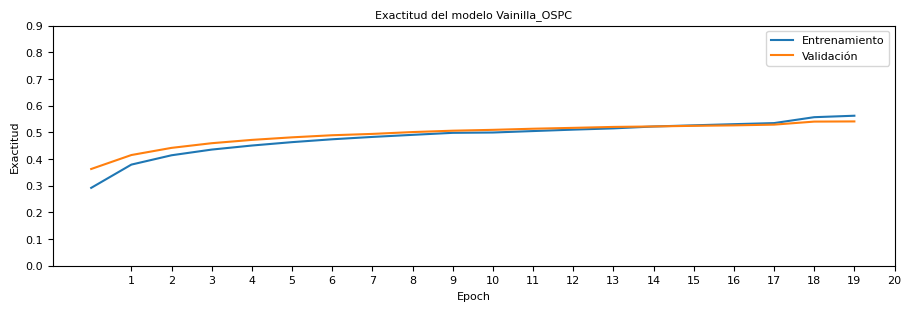

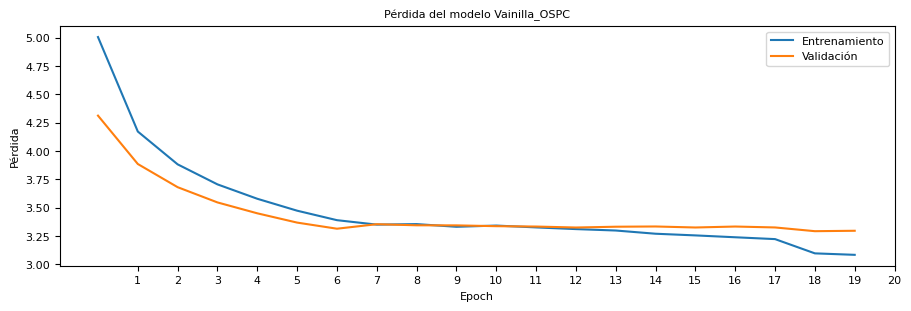

In [65]:
if DATASET == "OSPC":
    if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_Vainilla_OSPC, hist_model_Vainilla_OSPC, "OSPC")

In [66]:
if DATASET == "UNPC":
    if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_Vainilla_UNPC, unpc_tstset, DatasetScope.UN, tfrmr_st_greedy_decode)

In [67]:
if DATASET == "OSPC":
    if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_Vainilla_OSPC, ospc_tstset, DatasetScope.OS, tfrmr_st_greedy_decode)

In [68]:
if 1 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    del model_Vainilla_UNPC
    del model_Vainilla_OSPC

In [69]:
torch.cuda.mem_get_info()

(8349810688, 12884246528)

### **Modelo 2: Universal Transformer (UT)**

In [70]:
from TFM_RT import RecurrentTransformer, XT_Config


class UT_NMT(NeuralMachineTranslator):
    def __init__(self, name, size_of_src_vocab, size_of_tgt_vocab, max_length = UN_MAX_LEN, lr=TFMR_LR, device=None):
        super().__init__(name, lr)
        cfg = XT_Config(
            src_vocab_size=size_of_src_vocab,
            tgt_vocab_size=size_of_tgt_vocab,
            emb_dim = 512,
            hidden_dim = 1024,
            pff_dim = 1024,
            n_layers = 4,
            n_heads = 8,
            dropout_ratio =  0.1,
            max_len = max_length,
            pad_id=0,
            device=device
        )
        self.transformer = RecurrentTransformer(cfg)       
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        self.device = device

    def forward(self, x, y):
        a_hat = self.transformer(x, y)
        return a_hat
    
    def encode(self, x):
        mask = self.transformer.pad_mask(x)
        x = self.transformer.encoder(x, mask)
        return x, mask

    def decode(self, x, x_mask, latent):
        x = self.transformer.decoder(x, latent, x_mask,  None) 
        return x

    def isBatchSizeFirst(self):
        return True

In [71]:
def train_routine_ut(model : UT_NMT, dataset, device, clip=None, gc_count = 2):
    """
    Rutina de entrenamiento para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de entrenamiento sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio por época.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a entrenar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').
        clip (float, opcional): Valor opcional para aplicar clipping del gradiente. Default es None.

    Returns:
        float: Pérdida promedio por época.
        float: Precisión multietiqueta promedio por época.
        float: Precisión de Hamming promedio por época.
        int: Número total de muestras procesadas en la época.
    """
    model.train()       
    epoch_loss = 0
    epoch_accm = 0
    epoch_wmem = 0
    epoch_lmem = 0 

    i = 0

    batches_before_gc = 0

    criterion = MaskedAccuracy(1, device)

    for _, _, _, src, tgt, _, _ in iter(dataset):      
      
        src = src.permute(1,0)
        tgt = tgt.permute(1,0)

        tgt_i, tgt_o = shift(tgt, True)

        epoch_wmem += getSizeOf(src)
        epoch_wmem += getSizeOf(tgt)

        logits = model(src, tgt_i)

        logits = logits.transpose(1, 2)

        epoch_lmem += getSizeOf(logits)

        loss = model.update(logits, tgt_o)   
        
        accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

        epoch_wmem += getSizeOf(loss)
        epoch_wmem += getSizeOf(accm)

        epoch_loss += loss 
        epoch_accm += accm     

        if i % 100 == 99:           
            now = datetime.datetime.now()
            time_str = now.strftime("%Y-%m-%d %H:%M:%S")
            print(' [{0}] - train - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

        i += 1

        del src
        del tgt
        del loss
        del accm
        del logits

        if torch.cuda.is_available():
            batches_before_gc += 1
            if (batches_before_gc > gc_count):
                torch.cuda.empty_cache()       
                batches_before_gc = 0
    trn_loss = (epoch_loss / i).item()   
    trn_accm = (epoch_accm / i).item() 
    
    trn_wrkmem = (epoch_wmem / i) 
    trn_logmem = (epoch_lmem / i) 

    return trn_loss, trn_accm, trn_wrkmem, trn_logmem

In [72]:
def eval_routine_ut(model : UT_NMT, dataset, device, gc_count = 2):
    """
    Rutina de evaluación para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de evaluación sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a evaluar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').

    Returns:
        float: Pérdida promedio en la evaluación.
        float: Precisión multietiqueta promedio en la evaluación.
        float: Precisión de Hamming promedio en la evaluación.
        int: Número total de muestras evaluadas.
    """
    model.eval()    
    epoch_loss = 0
    epoch_accm = 0 
    epoch_wmem = 0
    epoch_lmem = 0 
    with torch.no_grad():  

        criterion = MaskedAccuracy(1, device)
        batches_before_gc = 0

        i = 0

        for  _, _, _, src, tgt, _, _ in iter(dataset):

            src = src.permute(1,0)
            tgt = tgt.permute(1,0)

            tgt_i, tgt_o = shift(tgt, True)
            
            epoch_wmem += getSizeOf(src)
            epoch_wmem += getSizeOf(tgt)

            logits = model(src, tgt_i)

            logits = logits.transpose(1, 2)

            epoch_lmem += getSizeOf(logits)

            loss = model.Loss(logits, tgt_o)   
            
            accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

            epoch_loss += loss 
            epoch_accm += accm

            if i % 100 == 99: 
                now = datetime.datetime.now()
                time_str = now.strftime("%Y-%m-%d %H:%M:%S")
                print(' [{0}] - eval - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

            epoch_wmem += getSizeOf(loss)
            epoch_wmem += getSizeOf(accm)

            i += 1

            del src
            del tgt
            del loss
            del accm
            del logits

            if torch.cuda.is_available():
                batches_before_gc += 1
                if (batches_before_gc > gc_count):
                    torch.cuda.empty_cache()       
                    batches_before_gc = 0

    val_loss = (epoch_loss / i).item()
    val_accm = (epoch_accm / i).item()
    val_wrkmem = epoch_wmem / i
    val_logmem = epoch_lmem / i
        
    return val_loss,  val_accm, val_wrkmem, val_logmem

In [73]:
if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_UT_UNPC = UT_NMT("UT_UNPC", unpc_en_vocab_size, unpc_es_vocab_size, max_length=UN_MAX_LEN, device=GPU)
    model_UT_UNPC.apply(weights_init_with_xavier)
    model_UT_UNPC = model_UT_UNPC.to(GPU)
    torch.compile(model_UT_UNPC)

In [74]:
if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_UT_OSPC = UT_NMT("UT_OSPC", ospc_en_vocab_size, ospc_es_vocab_size, max_length=OS_MAX_LEN, device=GPU)
    model_UT_OSPC.apply(weights_init_with_xavier)
    model_UT_OSPC = model_UT_OSPC.to(GPU)
    torch.compile(model_UT_OSPC)

In [75]:
if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_UT_UNPC)

Model 'UT_UNPC' has 253273385 trainable parameters.


In [76]:
if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_UT_OSPC)

Model 'UT_OSPC' has 200059142 trainable parameters.


In [77]:
if DATASET == "UNPC":
    if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_UT_UNPC = run_learning_cycle(model_UT_UNPC, universal_unpc_en_es_model_path, unpc_trnset, unpc_valset, fn_train=train_routine_ut, fn_eval=eval_routine_ut, max_epochs=NUMBER_OF_EPOCHS)

In [78]:
if DATASET == "OSPC":
    if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_UT_OSPC = run_learning_cycle(model_UT_OSPC, universal_ospc_en_es_model_path, ospc_trnset, ospc_valset, fn_train=train_routine_ut, fn_eval=eval_routine_ut, max_epochs=NUMBER_OF_EPOCHS)

UT_OSPC
Continuando entrenamiento del modelo UT_OSPC desde el checkpoint en la época 21
- Época 1 logra T.Pérdida = 4.36427879 E.Pérdida = 3.73084736 y T.Acc = 0.36915356 E.Acc = 0.43907055 Tiempo = 6726.576158479999 seg. 
- Época 2 logra T.Pérdida = 3.56481314 E.Pérdida = 3.42362237 y T.Acc = 0.45601103 E.Acc = 0.47597429 Tiempo = 6861.23408611 seg. 
- Época 3 logra T.Pérdida = 3.30865026 E.Pérdida = 3.27241731 y T.Acc = 0.48745573 E.Acc = 0.49617428 Tiempo = 6911.6428078300005 seg. 
- Época 4 logra T.Pérdida = 3.15457582 E.Pérdida = 3.18705845 y T.Acc = 0.50702107 E.Acc = 0.50750363 Tiempo = 6886.76320219 seg. 
- Época 5 logra T.Pérdida = 3.04473805 E.Pérdida = 3.13398433 y T.Acc = 0.52123415 E.Acc = 0.51362759 Tiempo = 6715.38125873 seg. 
- Época 6 logra T.Pérdida = 2.96182775 E.Pérdida = 3.09760904 y T.Acc = 0.53212237 E.Acc = 0.52041686 Tiempo = 6655.89719563 seg. 
- Época 7 logra T.Pérdida = 2.90894914 E.Pérdida = 3.10904646 y T.Acc = 0.54101622 E.Acc = 0.52468216 Tiempo = 6706.8

In [79]:
if DATASET == "UNPC":
    if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_UT_UNPC, hist_model_UT_UNPC, "UNPC")

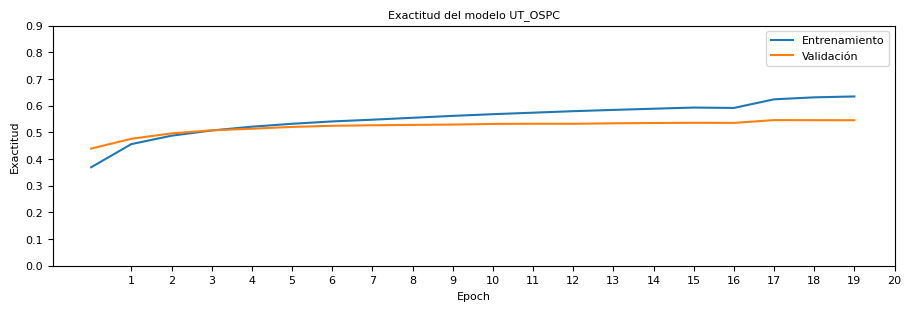

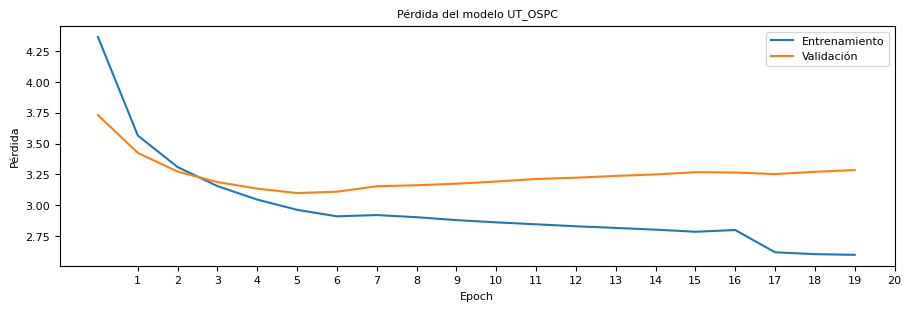

In [80]:
if DATASET == "OSPC":
    if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_UT_OSPC, hist_model_UT_OSPC, "OSPC")

In [81]:
def ut_st_greedy_decode(model : UT_NMT, src, max_len, bos_symbol, pad_symbol, eos_symbol):
    memory, mask = model.encode(src)
    output = torch.ones(1, 1, device = GPU).fill_(bos_symbol).type(torch.long)
    for i in range(max_len-1):
        logit  = model.decode(output, mask, memory)
        logit = model.transformer.generator(logit)
        next_token = torch.argmax(logit[:, -1], dim=-1)  
        next_token = next_token.item()
        next_token = torch.ones(1, 1, device=GPU).type_as(src.data).fill_(next_token)
        output = torch.cat([output, next_token], dim = 1)
        if next_token == eos_symbol:
            break
    return output

In [82]:
if DATASET == "UNPC":
    if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_UT_UNPC, unpc_tstset, DatasetScope.UN, ut_st_greedy_decode)

In [83]:
if DATASET == "OSPC":
    if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_UT_OSPC, ospc_tstset, DatasetScope.OS, ut_st_greedy_decode)

In [84]:
if 2 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    del model_UT_UNPC
    del model_UT_OSPC

In [85]:
torch.cuda.mem_get_info()

(7548698624, 12884246528)

### **Modelo 3: S5** Simplified Space-State Model (SSM)

In [86]:
# !pip install mamba-ssm

In [87]:

class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x)



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len = 5000, dropout = 0.1):
        super(PositionalEncoding, self).__init__()
        
        max_len = max_len # if config.task != 'summarization' else config.max_len * 4
        pe = torch.zeros(max_len, d_model)
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)



class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, device):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        bs = query.shape[0]

        Q = self.fc_q(query)  # (bs, q_len, d_model)
        K = self.fc_k(key)    # (bs, k_len, d_model)
        V = self.fc_v(value)  # (bs, v_len, d_model)

        Q = Q.view(bs, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  # (bs, n_heads, src_len, head_dim)
        K = K.view(bs, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  # (bs, n_heads, src_len, head_dim)
        V = V.view(bs, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  # (bs, n_heads, src_len, head_dim)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale  # (bs, n_heads, query_len, key_len)
        energy = self.dropout(energy)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(energy, dim=-1)    # (bs, n_heads, seq_len, seq_len)
        x = torch.matmul(attention, V)  # (bs, n_heads, seq_len, head_dim)
        x = x.permute(0, 2, 1, 3).contiguous()    # (bs, seq_len, n_heads, head_dim)
        x = x.view(bs, -1, self.d_model)   # (bs, seq_len, d_model)
        x = self.fc_o(x)     # x: (bs, seq_len, d_model)
        return x


In [88]:
from mamba_ssm import Mamba

class SSM_Unit(nn.Module):
     
     def __init__(self, d_model = 512, kernel_size = 4, hid_dim = 512,  n = 256, dropout = 0.1, layer_norm_eps: float = 1e-5, bias: bool = True, max_length = UN_MAX_LEN, device = None):
        super().__init__()
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.to_u = nn.Linear(d_model, d_model)  # Proyección de entrada
        self.to_v = nn.Linear(d_model, d_model)  # Proyección de entrada
        self.to_g = nn.Linear(d_model, d_model)  # Proyección de entrada
        self.norm = nn.LayerNorm(d_model, device=device)
        self.ssm = Mamba(
                            # This module uses roughly 3 * expand * d_model^2 parameters
                            d_model=d_model, # Model dimension d_model
                            d_state=16,  # SSM state expansion factor
                            d_conv=4,    # Local convolution width
                            expand=2,    # Block expansion factor
                        )
        self.to_o = nn.Linear(d_model, d_model)  # Proyección de entrada
        self.device = device

     def forward(self, x):
        residual, x = x, self.norm(x)
        u = F.gelu(self.to_u(x))
        v = F.gelu(self.to_v(x))
        v = self.ssm(v)
        g = self.to_g(v)
        o = self.to_o(g * u)
        return o + residual

class SSM_Encoder(nn.Module):
    def __init__(self, vocab_size, d_model = 512, kernel_size = 4, d_state = 16, n_blocks : int = 2, dropout = 0.1, layer_norm_eps: float = 1e-5, bias: bool = True, max_length = UN_MAX_LEN, device = None):
        super().__init__()
        self.tok_emb = Embedder(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_length, dropout=dropout)   
        self.mha = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.ssm_blocks = Mamba(
                            # This module uses roughly 3 * expand * d_model^2 parameters
                            d_model=d_model, # Model dimension d_model
                            d_state=d_state,  # SSM state expansion factor
                            d_conv=kernel_size,    # Local convolution width
                            expand=n_blocks,    # Block expansion factor
                        )
        self.ssm_blocks_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, device=device)
        self.ssm_dropout = nn.Dropout(dropout)
        self.ssm_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, device=device)
        self.device = device

    def forward(self, x, mask):
        x = self.tok_emb(x)
        x = self.pos_emb(x)            
        a = self.mha(query=x, key=x, value=x, mask=mask)
        x = self.mha_norm(x + self.dropout(a))
        x = self.ssm_blocks(x)
        return x

class SSM_Decoder(nn.Module):
    def __init__(self, vocab_size, d_model = 512, kernel_size = 4, d_state = 16, n_blocks : int = 2, dropout = 0.1, layer_norm_eps: float = 1e-5, bias: bool = True, max_length = UN_MAX_LEN, device = None):
        super().__init__()
        self.tok_emb = Embedder(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_length, dropout=dropout)  
        self.mha_1 = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_2 = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_1_norm = nn.LayerNorm(d_model)
        self.mha_2_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.ssm_blocks = Mamba(
                            # This module uses roughly 3 * expand * d_model^2 parameters
                            d_model=d_model, # Model dimension d_model
                            d_state=d_state,  # SSM state expansion factor
                            d_conv=kernel_size,    # Local convolution width
                            expand=n_blocks,    # Block expansion factor
                        )
        self.ssm_blocks_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, device=device)
        self.ssm_dropout = nn.Dropout(dropout)
        self.ssm_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, device=device)
        self.device = device

    def forward(self, x, mask, context, context_mask):
        x = self.tok_emb(x)
        x = self.pos_emb(x)
        # s-attn
        s = self.mha_1(query=x, key=x, value=x, mask=mask)
        x = self.mha_1_norm(x + self.dropout(s))
        # x-attn
        c = self.mha_2(query=x, key=context, value=context, mask=context_mask)
        x = self.mha_2_norm(x + self.dropout(c))
        x = self.ssm_blocks(x)
        return x

class SSM_NMT(NeuralMachineTranslator):
    def __init__(self, name, input_vocab_size, output_vocab_size, d_model = 512, n : int = 256, block_count : int = 4, dropout = 0.3,  lr=TFMR_LR, max_length = UN_MAX_LEN, device = None):
        super().__init__(name)
        self.src_pad_idx = UNPC_PAD_EN_IDX
        self.trg_pad_idx = UNPC_PAD_ES_IDX
        self.encoder = SSM_Encoder(input_vocab_size, d_model, n,  block_count, dropout, max_length = max_length, device = device)
        self.decoder = SSM_Decoder(output_vocab_size, d_model, n, block_count, dropout, max_length = max_length, device = device)
        self.projection = nn.Linear(d_model, output_vocab_size)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        self.device = device


    def make_src_mask(self, src):  # src: (bs, src_len)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask  # (bs, 1, 1, src_len)

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)  # (bs, 1, 1, trg_len)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()  # (trg_len, trg_len)
        trg_mask = trg_pad_mask & trg_sub_mask  # (bs, 1, trg_len, trg_len)
        return trg_mask

    def forward(self, src, tgt):
        s_mask = self.make_src_mask(src)
        t_mask = self.make_trg_mask(tgt)
        x = self.encoder(src, s_mask)
        x = self.decoder(tgt, t_mask, x, s_mask)
        x = self.projection(x)
        return x

    def encode(self, x):
        mask = self.make_src_mask(x)
        x = self.encoder(x, mask)
        return x, mask

    def decode(self, x, ctx, ctx_mask):
        mask = self.make_trg_mask(x)
        x = self.decoder(x, mask, ctx, ctx_mask) 
        return x
    
    def isBatchSizeFirst(self):
        return True

In [89]:
def train_routine_ssm(model : SSM_NMT, dataset, device, clip=None, gc_count = 2):
    model.train()       
    epoch_loss = 0
    epoch_accm = 0
    epoch_wmem = 0
    epoch_lmem = 0 

    i = 0

    batches_before_gc = 0

    criterion = MaskedAccuracy(1, device)

    for _, _, _, src, tgt, _, _ in iter(dataset):      
        
        src = src.permute(1, 0)
        tgt = tgt.permute(1, 0)

        tgt_i, tgt_o = shift(tgt, True)

        epoch_wmem += getSizeOf(src)
        epoch_wmem += getSizeOf(tgt)

        logits = model(src, tgt_i)

        epoch_lmem += getSizeOf(logits)

        logits = logits.transpose(1, 2)
        
        loss = model.update(logits, tgt_o)   
        
        accm = criterion(tgt_o, logits, UNPC_PAD_ES_IDX)   

        epoch_wmem += getSizeOf(loss)
        epoch_wmem += getSizeOf(accm)

        epoch_loss += loss 
        epoch_accm += accm     

        if i % 100 == 99:          
            now = datetime.datetime.now()
            time_str = now.strftime("%Y-%m-%d %H:%M:%S")
            print(' [{0}] - train - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

        i += 1

        del src
        del tgt
        del loss
        del accm
        del logits

        if torch.cuda.is_available():
            batches_before_gc += 1
            if (batches_before_gc > gc_count):
                torch.cuda.empty_cache()       
                batches_before_gc = 0
                
    trn_loss = (epoch_loss / i).item()   
    trn_accm = (epoch_accm / i).item() 
    
    trn_wrkmem = (epoch_wmem / i) 
    trn_logmem = (epoch_lmem / i) 

    return trn_loss, trn_accm, trn_wrkmem, trn_logmem

In [90]:
def eval_routine_ssm(model : SSM_NMT, dataset, device, gc_count = 2):
    """
    Rutina de evaluación para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de evaluación sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a evaluar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').

    Returns:
        float: Pérdida promedio en la evaluación.
        float: Precisión multietiqueta promedio en la evaluación.
        float: Precisión de Hamming promedio en la evaluación.
        int: Número total de muestras evaluadas.
    """
    model.eval()    
    epoch_loss = 0
    epoch_accm = 0 
    epoch_wmem = 0
    epoch_lmem = 0 
    with torch.no_grad():  

        criterion = MaskedAccuracy(1, device)
        batches_before_gc = 0

        i = 0

        for  _, _, _, src, tgt, _, _ in iter(dataset):
            
            src = src.permute(1, 0)
            tgt = tgt.permute(1, 0)

            tgt_i, tgt_o = shift(tgt, True)
            
            epoch_wmem += getSizeOf(src)
            epoch_wmem += getSizeOf(tgt)

            logits = model(src, tgt_i)

            logits = logits.transpose(1, 2)

            epoch_lmem += getSizeOf(logits)


            loss = model.Loss(logits, tgt_o)   
            
            accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

            epoch_loss += loss 
            epoch_accm += accm

            if i % 100 == 99: 
                now = datetime.datetime.now()
                time_str = now.strftime("%Y-%m-%d %H:%M:%S")
                print(' [{0}] - eval - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

            epoch_wmem += getSizeOf(loss)
            epoch_wmem += getSizeOf(accm)

            i += 1

            del src
            del tgt
            del logits
            del loss
            del accm
            if torch.cuda.is_available():
                batches_before_gc += 1
                if (batches_before_gc > gc_count):
                    torch.cuda.empty_cache()       
                    batches_before_gc = 0

    val_loss = (epoch_loss / i).item()
    val_accm = (epoch_accm / i).item()
    val_wrkmem = epoch_wmem / i
    val_logmem = epoch_lmem / i
        
    return val_loss,  val_accm, val_wrkmem, val_logmem

In [91]:
if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_SSM_UNPC = SSM_NMT("SSM_UNPC", unpc_en_vocab_size, unpc_es_vocab_size, max_length=UN_MAX_LEN, device=GPU)
    model_SSM_UNPC.apply(weights_init_with_xavier)
    model_SSM_UNPC = model_SSM_UNPC.to(GPU)
    torch.compile(model_SSM_UNPC)

In [92]:
if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_SSM_OSPC = SSM_NMT("SSM_OSPC", ospc_en_vocab_size, ospc_es_vocab_size, max_length=OS_MAX_LEN, device=GPU)
    model_SSM_OSPC.apply(weights_init_with_xavier)
    model_SSM_OSPC = model_SSM_OSPC.to(GPU)
    torch.compile(model_SSM_OSPC)

In [93]:
if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_SSM_UNPC)

Model 'SSM_UNPC' has 176604055 trainable parameters.


In [94]:
if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_SSM_OSPC)

Model 'SSM_OSPC' has 137301364 trainable parameters.


In [95]:
if DATASET == "UNPC":
    if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_SSM_UNPC = run_learning_cycle(model_SSM_UNPC, mamba_unpc_en_es_model_path, unpc_trnset, unpc_valset, 
                                                    fn_train=train_routine_ssm, fn_eval=eval_routine_ssm, max_epochs=NUMBER_OF_EPOCHS)

In [96]:
if DATASET == "OSPC":
    if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_SSM_OSPC = run_learning_cycle(model_SSM_OSPC, mamba_ospc_en_es_model_path, ospc_trnset, ospc_valset, 
                                                    fn_train=train_routine_ssm, fn_eval=eval_routine_ssm, max_epochs=NUMBER_OF_EPOCHS)

SSM_OSPC
Continuando entrenamiento del modelo SSM_OSPC desde el checkpoint en la época 21
- Época 1 logra T.Pérdida = 5.34559774 E.Pérdida = 4.65497398 y T.Acc = 0.25474614 E.Acc = 0.3293651 Tiempo = 4396.12159932 seg. 
- Época 2 logra T.Pérdida = 4.45124102 E.Pérdida = 4.18074751 y T.Acc = 0.34692782 E.Acc = 0.38891795 Tiempo = 4272.4694302 seg. 
- Época 3 logra T.Pérdida = 4.13710928 E.Pérdida = 3.95683718 y T.Acc = 0.38614205 E.Acc = 0.4172214 Tiempo = 4591.4318929 seg. 
- Época 4 logra T.Pérdida = 3.96303558 E.Pérdida = 3.81359529 y T.Acc = 0.40845335 E.Acc = 0.43300849 Tiempo = 4368.426144630001 seg. 
- Época 5 logra T.Pérdida = 3.85332417 E.Pérdida = 3.72422576 y T.Acc = 0.42266533 E.Acc = 0.44744283 Tiempo = 4476.67334072 seg. 
- Época 6 logra T.Pérdida = 3.77295256 E.Pérdida = 3.66436648 y T.Acc = 0.43319526 E.Acc = 0.45557743 Tiempo = 4440.6918577100005 seg. 
- Época 7 logra T.Pérdida = 3.71027184 E.Pérdida = 3.62965417 y T.Acc = 0.44112849 E.Acc = 0.4602209 Tiempo = 4461.0827

In [97]:
if DATASET == "UNPC":
    if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_SSM_UNPC, hist_model_SSM_UNPC, "UNPC")

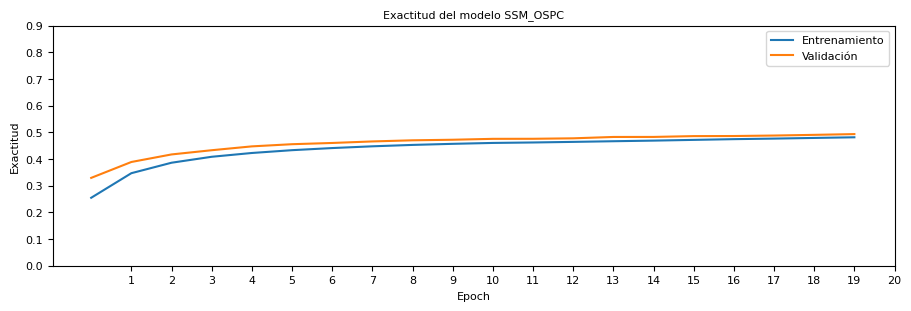

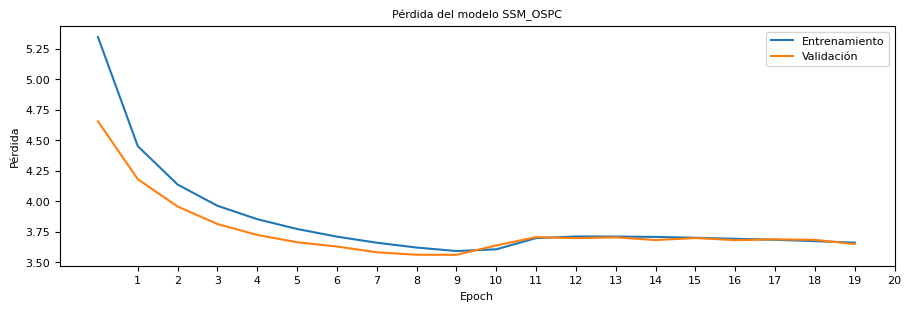

In [98]:
if DATASET == "OSPC":
    if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_SSM_OSPC, hist_model_SSM_OSPC, "OSPC")

In [99]:
def ssm_st_greedy_decode(model : SSM_NMT, src, max_len, bos_symbol, pad_symbol, eos_symbol):
    memory, memory_mask = model.encode(src)
    output = torch.ones(1, 1, device = GPU).fill_(bos_symbol).type(torch.long)
    for i in range(max_len-1):
        d_out  = model.decode(output, memory, memory_mask)
        logit = model.projection(d_out)       
        next_token = torch.argmax(logit[:, -1], dim=-1)  
        next_token = next_token.item()
        next_token = torch.ones(1, 1, device=GPU).type_as(src.data).fill_(next_token)
        output = torch.cat([output, next_token], dim = 1)
        if next_token == eos_symbol:
            break
    return output

In [100]:
if DATASET == "UNPC":
    if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_SSM_UNPC, unpc_tstset, DatasetScope.UN, ssm_st_greedy_decode)

In [101]:
if DATASET == "OSPC":
    if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_SSM_OSPC, ospc_tstset, DatasetScope.OS, ssm_st_greedy_decode)

In [102]:
if 3 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    del model_SSM_UNPC
    del model_SSM_OSPC

In [103]:
torch.cuda.mem_get_info()

(8706326528, 12884246528)

### **Modelo 4: ST-MoE Transformer**

In [104]:
# !pip install st-moe-pytorch

In [105]:

from st_moe_pytorch import MoE, SparseMoEBlock
from taylor_series_linear_attention import TaylorSeriesLinearAttn


class MoE_Encoder(nn.Module):
    def __init__(self, vocab_size,  d_model = 512, max_length = 128, dropout = 0.10, layer_norm_eps: float = 1e-5, bias: bool = True, device = None):
        super().__init__()
        self.tok_emb = Embedder(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_length, dropout=dropout)       

        self.mha = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        enc_moe = MoE(
            dim = d_model,
            num_experts = 8,               # increase the experts (# parameters) of your model without increasing computation
            gating_top_n = 2,               # default to top 2 gating, but can also be more (3 was tested in the paper with a lower threshold)
            threshold_train = 0.2,          # at what threshold to accept a token to be routed to second expert and beyond - 0.2 was optimal for 2 expert routing, and apparently should be lower for 3
            threshold_eval = 0.2,
            capacity_factor_train = 1.25,   # experts have fixed capacity per batch. we need some extra capacity in case gating is not perfectly balanced.
            capacity_factor_eval = 2.,      # capacity_factor_* should be set to a value >=1
            balance_loss_coef = 1e-2,       # multiplier on the auxiliary expert balancing auxiliary loss
            router_z_loss_coef = 1e-3,      # loss weight for router z-loss
        )

        self.moe_block = SparseMoEBlock(enc_moe, add_ff_before = True, add_ff_after = True)
        self.moe_dropout = nn.Dropout(dropout)
        self.moe_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, device=device)
        self.device = device

    def forward(self, x, mask):
        x = self.tok_emb(x)
        x = self.pos_emb(x)

        a = self.mha(query=x, key=x, value=x, mask=mask)
        x = self.mha_norm(x + self.dropout(a))
        
        r, _, _, _ = self.moe_block(x)

        r = self.moe_dropout(r)

        x = x + r
        x = self.moe_norm(x)

        return x
    

class MoE_Decoder(nn.Module):
    def __init__(self, vocab_size,  d_model = 512, max_length = UN_MAX_LEN, dropout = 0.10, layer_norm_eps: float = 1e-5, bias: bool = True, device = None):
        super().__init__()
        self.tok_emb = Embedder(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_length, dropout=dropout) 

        self.mha_1 = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_2 = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_1_norm = nn.LayerNorm(d_model)
        self.mha_2_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)


        enc_moe = MoE(
            dim = d_model,
            num_experts = 8,               # increase the experts (# parameters) of your model without increasing computation
            gating_top_n = 2,               # default to top 2 gating, but can also be more (3 was tested in the paper with a lower threshold)
            threshold_train = 0.2,          # at what threshold to accept a token to be routed to second expert and beyond - 0.2 was optimal for 2 expert routing, and apparently should be lower for 3
            threshold_eval = 0.2,
            capacity_factor_train = 1.25,   # experts have fixed capacity per batch. we need some extra capacity in case gating is not perfectly balanced.
            capacity_factor_eval = 2.,      # capacity_factor_* should be set to a value >=1
            balance_loss_coef = 1e-2,       # multiplier on the auxiliary expert balancing auxiliary loss
            router_z_loss_coef = 1e-3,      # loss weight for router z-loss
        )
        self.moe_block = SparseMoEBlock(enc_moe, add_ff_before = True, add_ff_after = True)
        self.moe_dropout = nn.Dropout(dropout)
        self.moe_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, bias=bias, device=device)
        self.device = device

    def forward(self, x, mask, context, context_mask): 
        x = self.tok_emb(x)
        x = self.pos_emb(x)

        # s-attn
        s = self.mha_1(query=x, key=x, value=x, mask=mask)
        x = self.mha_1_norm(x + self.dropout(s))

        # x-attn
        c = self.mha_2(query=x, key=context, value=context, mask=context_mask)
        x = self.mha_2_norm(x + self.dropout(c))

        r, _, _, _ = self.moe_block(x)

        r = self.moe_dropout(r)

        x = x + r
        x = self.moe_norm(x)
        return x


class MoE_NMT(NeuralMachineTranslator):
    def __init__(self, name, size_of_src_vocab, size_of_tgt_vocab,  d_model = 512, lr = TFMR_LR, max_seq_length = UN_MAX_LEN, device = None):
        super().__init__(name)      
        self.src_pad_idx = UNPC_PAD_EN_IDX
        self.trg_pad_idx = UNPC_PAD_ES_IDX
        self.encoder = MoE_Encoder(size_of_src_vocab, d_model, max_length=max_seq_length, device=device)
        self.decoder = MoE_Decoder(size_of_tgt_vocab, d_model, max_length=max_seq_length, device=device)
        self.generator = nn.Linear(d_model, size_of_tgt_vocab)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        self.device = device

    def make_src_mask(self, src):  # src: (bs, src_len)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask  # (bs, 1, 1, src_len)

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)  # (bs, 1, 1, trg_len)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()  # (trg_len, trg_len)
        trg_mask = trg_pad_mask & trg_sub_mask  # (bs, 1, trg_len, trg_len)
        return trg_mask


    def forward(self, src, tgt):
        s_mask = self.make_src_mask(src)
        t_mask = self.make_trg_mask(tgt)
        x = self.encoder(src, s_mask)
        x = self.decoder(tgt, t_mask, x, s_mask)
        x = self.generator(x)
        return x

    def encode(self, x):
        mask = self.make_src_mask(x)
        x = self.encoder(x, mask)
        return x, mask

    def decode(self, x, ctx, ctx_mask):
        mask = self.make_trg_mask(x)
        x = self.decoder(x, mask, ctx, ctx_mask) 
        return x

    def isBatchSizeFirst(self):
        return True

In [106]:
def train_routine_moe(model : MoE_NMT, dataset, device, clip=None, gc_count = 2):
    """
    Rutina de entrenamiento para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de entrenamiento sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio por época.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a entrenar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').
        clip (float, opcional): Valor opcional para aplicar clipping del gradiente. Default es None.

    Returns:
        float: Pérdida promedio por época.
        float: Precisión multietiqueta promedio por época.
        float: Precisión de Hamming promedio por época.
        int: Número total de muestras procesadas en la época.
    """
    model.train()       
    epoch_loss = 0
    epoch_accm = 0
    epoch_wmem = 0
    epoch_lmem = 0 

    i = 0

    batches_before_gc = 0

    criterion = MaskedAccuracy(1, device)

    for _, _, _, src, tgt, _, _ in iter(dataset):      
      
        src = src.permute(1,0)
        tgt = tgt.permute(1,0)

        tgt_i ,  tgt_o = shift(tgt, True)

        epoch_wmem += getSizeOf(src)
        epoch_wmem += getSizeOf(tgt)

        logits = model(src, tgt_i)

        logits = logits.transpose(1, 2)

        epoch_lmem += getSizeOf(logits)

        loss = model.update(logits, tgt_o)   
        
        accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

        epoch_wmem += getSizeOf(loss)
        epoch_wmem += getSizeOf(accm)

        epoch_loss += loss 
        epoch_accm += accm     

        if i % 100 == 99:           
            now = datetime.datetime.now()
            time_str = now.strftime("%Y-%m-%d %H:%M:%S")
            print(' [{0}] - train - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

        i += 1

        del src
        del tgt
        del loss
        del accm
        del logits

        if torch.cuda.is_available():
            batches_before_gc += 1
            if (batches_before_gc > gc_count):
                torch.cuda.empty_cache()       
                batches_before_gc = 0
    trn_loss = (epoch_loss / i).item()   
    trn_accm = (epoch_accm / i).item() 
    
    trn_wrkmem = (epoch_wmem / i) 
    trn_logmem = (epoch_lmem / i) 

    return trn_loss, trn_accm, trn_wrkmem, trn_logmem

In [107]:
def eval_routine_moe(model : MoE_NMT, dataset, device, gc_count = 2):
    """
    Rutina de evaluación para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de evaluación sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a evaluar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').

    Returns:
        float: Pérdida promedio en la evaluación.
        float: Precisión multietiqueta promedio en la evaluación.
        float: Precisión de Hamming promedio en la evaluación.
        int: Número total de muestras evaluadas.
    """
    model.eval()    
    epoch_loss = 0
    epoch_accm = 0 
    epoch_wmem = 0
    epoch_lmem = 0 
    with torch.no_grad():  

        criterion = MaskedAccuracy(1, device)
        batches_before_gc = 0

        i = 0

        for  _, _, _, src, tgt, _, _ in iter(dataset):

            src = src.permute(1,0)
            tgt = tgt.permute(1,0)

            tgt_i , tgt_o = shift(tgt, True)
            
            epoch_wmem += getSizeOf(src)
            epoch_wmem += getSizeOf(tgt)

            logits = model(src, tgt_i)
            logits = logits.transpose(1, 2)

            epoch_lmem += getSizeOf(logits)
       
            loss = model.Loss(logits, tgt_o)   
            
            accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

            epoch_loss += loss 
            epoch_accm += accm

            if i % 100 == 99: 
                now = datetime.datetime.now()
                time_str = now.strftime("%Y-%m-%d %H:%M:%S")
                print(' [{0}] - eval - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

            epoch_wmem += getSizeOf(loss)
            epoch_wmem += getSizeOf(accm)

            i += 1

            del src
            del tgt
            del logits
            del loss
            del accm
            if torch.cuda.is_available():
                batches_before_gc += 1
                if (batches_before_gc > gc_count):
                    torch.cuda.empty_cache()       
                    batches_before_gc = 0

    val_loss = (epoch_loss / i).item()
    val_accm = (epoch_accm / i).item()
    val_wrkmem = epoch_wmem / i
    val_logmem = epoch_lmem / i
        
    return val_loss,  val_accm, val_wrkmem, val_logmem



In [108]:
if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_MOE_UNPC = MoE_NMT("MoE_UNPC", unpc_en_vocab_size, unpc_es_vocab_size, max_seq_length=UN_MAX_LEN, device=GPU)
    model_MOE_UNPC.apply(weights_init_with_xavier)
    model_MOE_UNPC = model_MOE_UNPC.to(GPU)
    torch.compile(model_MOE_UNPC)

In [109]:
if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_MOE_OSPC = MoE_NMT("MoE_OSPC", ospc_en_vocab_size, ospc_es_vocab_size, max_seq_length=OS_MAX_LEN, device=GPU)
    model_MOE_OSPC.apply(weights_init_with_xavier)
    model_MOE_OSPC = model_MOE_OSPC.to(GPU)
    torch.compile(model_MOE_OSPC)

In [110]:
if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_MOE_UNPC)

Model 'MoE_UNPC' has 218065685 trainable parameters.


In [111]:
if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_MOE_OSPC)

Model 'MoE_OSPC' has 178762994 trainable parameters.


In [112]:
if DATASET == "UNPC":
    if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_MOE_UNPC = run_learning_cycle(model_MOE_UNPC, moe_unpc_en_es_model_path, unpc_trnset, unpc_valset, 
                                                 fn_train=train_routine_moe, fn_eval=eval_routine_moe, max_epochs=NUMBER_OF_EPOCHS)

In [113]:
if DATASET == "OSPC":
    if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_MOE_OSPC = run_learning_cycle(model_MOE_OSPC, moe_ospc_en_es_model_path, ospc_trnset, ospc_valset, 
                                                 fn_train=train_routine_moe, fn_eval=eval_routine_moe, max_epochs=NUMBER_OF_EPOCHS)

MoE_OSPC
Continuando entrenamiento del modelo MoE_OSPC desde el checkpoint en la época 21
- Época 1 logra T.Pérdida = 4.58652258 E.Pérdida = 3.87679791 y T.Acc = 0.35124767 E.Acc = 0.43095177 Tiempo = 5266.21630432 seg. 
- Época 2 logra T.Pérdida = 3.79509687 E.Pérdida = 3.5595355 y T.Acc = 0.43844309 E.Acc = 0.46828157 Tiempo = 5399.56952742 seg. 
- Época 3 logra T.Pérdida = 3.55895996 E.Pérdida = 3.41232228 y T.Acc = 0.4680711 E.Acc = 0.48766363 Tiempo = 5267.746454749999 seg. 
- Época 4 logra T.Pérdida = 3.41551638 E.Pérdida = 3.33095884 y T.Acc = 0.48633546 E.Acc = 0.49855891 Tiempo = 5079.92886794 seg. 
- Época 5 logra T.Pérdida = 3.30446577 E.Pérdida = 3.2717371 y T.Acc = 0.49965373 E.Acc = 0.50698048 Tiempo = 5296.09659122 seg. 
- Época 6 logra T.Pérdida = 3.20933557 E.Pérdida = 3.25265765 y T.Acc = 0.51020467 E.Acc = 0.51215655 Tiempo = 5433.447368579999 seg. 
- Época 7 logra T.Pérdida = 3.15812182 E.Pérdida = 3.26068115 y T.Acc = 0.51937366 E.Acc = 0.51690722 Tiempo = 4998.287

In [114]:
if DATASET == "UNPC":
    if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_MOE_UNPC, hist_model_MOE_UNPC, "UNPC")

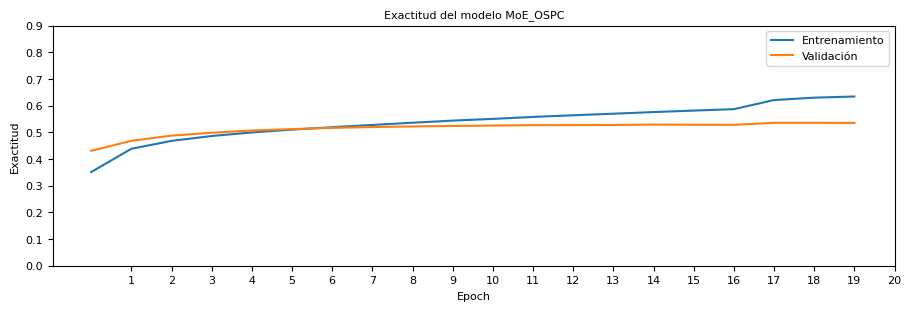

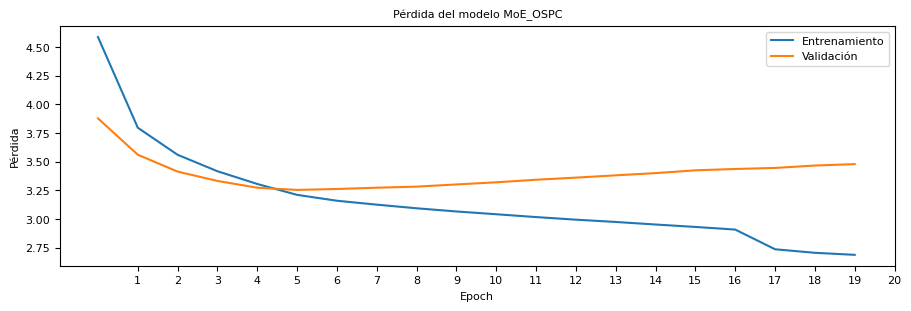

In [115]:
if DATASET == "OSPC":
    if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_MOE_OSPC, hist_model_MOE_OSPC, "OSPC")

In [116]:

def moe_st_greedy_decode(model : MoE_NMT, src, max_len, bos_symbol, pad_symbol, eos_symbol):  
    memory, memory_mask = model.encode(src)
    output = torch.ones(1, 1, device = GPU).fill_(bos_symbol).type(torch.long)
    for i in range(max_len-1):
        d_out  = model.decode(output, memory, memory_mask)
        logit = model.generator(d_out)       
        next_token = torch.argmax(logit[:, -1], dim=-1)  
        next_token = next_token.item()
        next_token = torch.ones(1, 1, device=GPU).type_as(src.data).fill_(next_token)
        output = torch.cat([output, next_token], dim = 1)
        if next_token == eos_symbol:
            break
    return output

In [117]:
if DATASET == "UNPC":
    if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_MOE_UNPC, unpc_tstset, DatasetScope.UN, moe_st_greedy_decode)

In [118]:
if DATASET == "OSPC":
    if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_MOE_OSPC, ospc_tstset, DatasetScope.OS, moe_st_greedy_decode)

In [119]:
if 4 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    del model_MOE_UNPC
    del model_MOE_OSPC

In [120]:
torch.cuda.mem_get_info()

(7980711936, 12884246528)

### **Modelo 5: Gated State Spaces**

In [121]:
# https://arxiv.org/pdf/2206.13947
# $pip install gated-state-spaces-pytorch

In [122]:
from gated_state_spaces_pytorch import GSS

class GSS_Encoder(nn.Module):
    def __init__(self, vocab_size,  d_model = 512, depth = 3, max_length = 128, dropout = 0.10, device = None):
        super().__init__()
        self.tok_emb = Embedder(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_length, dropout=dropout)       

        self.mha = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)


        self.layers = nn.ModuleList(
            [
                GSS(
                    dim = d_model,
                    dss_kernel_H = 512,
                    dss_kernel_N = 256,
                    dim_expansion_factor = 4,
                    dss_kernel_lambda_imag_exp = True
                ).cuda()
                for _ in range(depth)
            ]
        )

        self.device = device

    def forward(self, x, mask):
        x = self.tok_emb(x)
        x = self.pos_emb(x)

        a = self.mha(query=x, key=x, value=x, mask=mask)
        x = self.mha_norm(x + self.dropout(a))
        
        r = x
        for gss in self.layers:
            r = gss(r)

        return r
    

class GSS_Decoder(nn.Module):
    def __init__(self, vocab_size,  d_model = 512, depth = 3, max_length = UN_MAX_LEN, dropout = 0.10, device = None):
        super().__init__()
        self.tok_emb = Embedder(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_length, dropout=dropout) 

        self.mha_1 = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_2 = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_1_norm = nn.LayerNorm(d_model)
        self.mha_2_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList(
            [
                GSS(
                    dim = d_model,
                    dss_kernel_H = 512,
                    dss_kernel_N = 256,
                    dim_expansion_factor = 4,
                    dss_kernel_lambda_imag_exp = True
                ).cuda()
                for _ in range(depth)
            ]
        )
        self.device = device

    def forward(self, x, mask, context, context_mask): 
        x = self.tok_emb(x)
        x = self.pos_emb(x)

        # s-attn
        s = self.mha_1(query=x, key=x, value=x, mask=mask)
        x = self.mha_1_norm(x + self.dropout(s))

        # x-attn
        c = self.mha_2(query=x, key=context, value=context, mask=context_mask)
        x = self.mha_2_norm(x + self.dropout(c))

        r = x
        for gss in self.layers:
            r = gss(r)
        return r


class GSS_NMT(NeuralMachineTranslator):
    def __init__(self, name, size_of_src_vocab, size_of_tgt_vocab,  d_model = 512, lr = TFMR_LR, max_seq_length = UN_MAX_LEN, device = None):
        super().__init__(name)      
        self.src_pad_idx = UNPC_PAD_EN_IDX
        self.trg_pad_idx = UNPC_PAD_ES_IDX
        self.encoder = GSS_Encoder(size_of_src_vocab, d_model, max_length=max_seq_length, device=device)
        self.decoder = GSS_Decoder(size_of_tgt_vocab, d_model, max_length=max_seq_length, device=device)
        self.generator = nn.Linear(d_model, size_of_tgt_vocab)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        self.device = device

    def make_src_mask(self, src):  # src: (bs, src_len)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask  # (bs, 1, 1, src_len)

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)  # (bs, 1, 1, trg_len)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()  # (trg_len, trg_len)
        trg_mask = trg_pad_mask & trg_sub_mask  # (bs, 1, trg_len, trg_len)
        return trg_mask


    def forward(self, src, tgt):
        s_mask = self.make_src_mask(src)
        t_mask = self.make_trg_mask(tgt)
        x = self.encoder(src, s_mask)
        x = self.decoder(tgt, t_mask, x, s_mask)
        x = self.generator(x)
        return x

    def encode(self, x):
        mask = self.make_src_mask(x)
        x = self.encoder(x, mask)
        return x, mask

    def decode(self, x, ctx, ctx_mask):
        mask = self.make_trg_mask(x)
        x = self.decoder(x, mask, ctx, ctx_mask) 
        return x
    
    def isBatchSizeFirst(self):
        return True

In [123]:
def train_routine_gss(model : GSS_NMT, dataset, device, clip=None, gc_count = 2):
    """
    Rutina de entrenamiento para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de entrenamiento sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio por época.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a entrenar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').
        clip (float, opcional): Valor opcional para aplicar clipping del gradiente. Default es None.

    Returns:
        float: Pérdida promedio por época.
        float: Precisión multietiqueta promedio por época.
        float: Precisión de Hamming promedio por época.
        int: Número total de muestras procesadas en la época.
    """
    model.train()       
    epoch_loss = 0
    epoch_accm = 0
    epoch_wmem = 0
    epoch_lmem = 0 

    i = 0

    batches_before_gc = 0

    criterion = MaskedAccuracy(1, device)

    for _, _, _, src, tgt, _, _ in iter(dataset):      
      
        src = src.permute(1,0)
        tgt = tgt.permute(1,0)

        tgt_i ,  tgt_o = shift(tgt, True)

        epoch_wmem += getSizeOf(src)
        epoch_wmem += getSizeOf(tgt)

        logits = model(src, tgt_i)

        logits = logits.transpose(1, 2)

        epoch_lmem += getSizeOf(logits)

        loss = model.update(logits, tgt_o)   
        
        accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

        epoch_wmem += getSizeOf(loss)
        epoch_wmem += getSizeOf(accm)

        epoch_loss += loss 
        epoch_accm += accm     

        if i % 100 == 99:           
            now = datetime.datetime.now()
            time_str = now.strftime("%Y-%m-%d %H:%M:%S")
            print(' [{0}] - train - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

        i += 1

        del src
        del tgt
        del loss
        del accm
        del logits

        if torch.cuda.is_available():
            batches_before_gc += 1
            if (batches_before_gc > gc_count):
                torch.cuda.empty_cache()       
                batches_before_gc = 0
    trn_loss = (epoch_loss / i).item()   
    trn_accm = (epoch_accm / i).item() 
    
    trn_wrkmem = (epoch_wmem / i) 
    trn_logmem = (epoch_lmem / i) 

    return trn_loss, trn_accm, trn_wrkmem, trn_logmem


In [124]:
def eval_routine_gss(model : GSS_NMT, dataset, device, gc_count = 2):
    """
    Rutina de evaluación para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de evaluación sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a evaluar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').

    Returns:
        float: Pérdida promedio en la evaluación.
        float: Precisión multietiqueta promedio en la evaluación.
        float: Precisión de Hamming promedio en la evaluación.
        int: Número total de muestras evaluadas.
    """
    model.eval()    
    epoch_loss = 0
    epoch_accm = 0 
    epoch_wmem = 0
    epoch_lmem = 0 
    with torch.no_grad():  

        criterion = MaskedAccuracy(1, device)
        batches_before_gc = 0

        i = 0

        for  _, _, _, src, tgt, _, _ in iter(dataset):

            src = src.permute(1,0)
            tgt = tgt.permute(1,0)

            tgt_i , tgt_o = shift(tgt, True)
            
            epoch_wmem += getSizeOf(src)
            epoch_wmem += getSizeOf(tgt)

            logits = model(src, tgt_i)
            logits = logits.transpose(1, 2)

            epoch_lmem += getSizeOf(logits)
       
            loss = model.Loss(logits, tgt_o)   
            
            accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

            epoch_loss += loss 
            epoch_accm += accm

            if i % 100 == 99: 
                now = datetime.datetime.now()
                time_str = now.strftime("%Y-%m-%d %H:%M:%S")
                print(' [{0}] - eval - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

            epoch_wmem += getSizeOf(loss)
            epoch_wmem += getSizeOf(accm)

            i += 1

            del src
            del tgt
            del logits
            del loss
            del accm
            if torch.cuda.is_available():
                batches_before_gc += 1
                if (batches_before_gc > gc_count):
                    torch.cuda.empty_cache()       
                    batches_before_gc = 0

    val_loss = (epoch_loss / i).item()
    val_accm = (epoch_accm / i).item()
    val_wrkmem = epoch_wmem / i
    val_logmem = epoch_lmem / i
        
    return val_loss,  val_accm, val_wrkmem, val_logmem


In [125]:
if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_GSS_UNPC = GSS_NMT("GSS_UNPC", unpc_en_vocab_size, unpc_es_vocab_size, max_seq_length=UN_MAX_LEN, device=GPU)
    model_GSS_UNPC.apply(weights_init_with_xavier)
    model_GSS_UNPC = model_GSS_UNPC.to(GPU)
    torch.compile(model_GSS_UNPC)

In [126]:
if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_GSS_OSPC = GSS_NMT("GSS_OSPC", ospc_en_vocab_size, ospc_es_vocab_size, max_seq_length=OS_MAX_LEN, device=GPU)
    model_GSS_OSPC.apply(weights_init_with_xavier)
    model_GSS_OSPC = model_GSS_OSPC.to(GPU)
    torch.compile(model_GSS_OSPC)

In [127]:
if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_GSS_UNPC)

Model 'GSS_UNPC' has 198069033 trainable parameters.


In [128]:
if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_GSS_OSPC)

Model 'GSS_OSPC' has 158766342 trainable parameters.


In [129]:
if DATASET == "UNPC":
    if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1):     
        hist_model_GSS_UNPC = run_learning_cycle(model_GSS_UNPC, gss_unpc_en_es_model_path, unpc_trnset, unpc_valset, 
                                                 fn_train=train_routine_gss, fn_eval=eval_routine_gss, max_epochs=NUMBER_OF_EPOCHS)

In [130]:
if DATASET == "OSPC":
    if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_GSS_OSPC = run_learning_cycle(model_GSS_OSPC, gss_ospc_en_es_model_path, ospc_trnset, ospc_valset, 
                                                 fn_train=train_routine_gss, fn_eval=eval_routine_gss, max_epochs=NUMBER_OF_EPOCHS)

GSS_OSPC
Continuando entrenamiento del modelo GSS_OSPC desde el checkpoint en la época 21
- Época 1 logra T.Pérdida = 5.03108597 E.Pérdida = 4.57238007 y T.Acc = 0.29067907 E.Acc = 0.33511236 Tiempo = 5719.26085273 seg. 
- Época 2 logra T.Pérdida = 4.53181553 E.Pérdida = 4.37329054 y T.Acc = 0.33517793 E.Acc = 0.3551051 Tiempo = 5750.64442158 seg. 
- Época 3 logra T.Pérdida = 4.46695662 E.Pérdida = 4.39359331 y T.Acc = 0.34117806 E.Acc = 0.35159764 Tiempo = 5686.99516116 seg. 
- Época 4 logra T.Pérdida = 4.46401262 E.Pérdida = 4.48123932 y T.Acc = 0.34118479 E.Acc = 0.33686563 Tiempo = 5779.54030506 seg. 
- Época 5 logra T.Pérdida = 4.53955841 E.Pérdida = 4.37688637 y T.Acc = 0.33034667 E.Acc = 0.35547057 Tiempo = 6169.701301720001 seg. 
- Época 6 logra T.Pérdida = 4.46862555 E.Pérdida = 4.39570284 y T.Acc = 0.33923885 E.Acc = 0.35405269 Tiempo = 8626.13378181 seg. 
- Época 7 logra T.Pérdida = 4.5182209 E.Pérdida = 4.44426298 y T.Acc = 0.33419186 E.Acc = 0.34651226 Tiempo = 4850.913321

In [131]:
if DATASET == "UNPC":
    if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_GSS_UNPC, hist_model_GSS_UNPC, "UNPC")

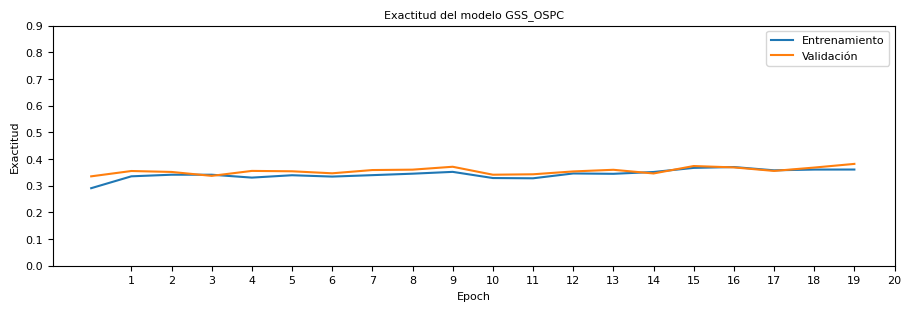

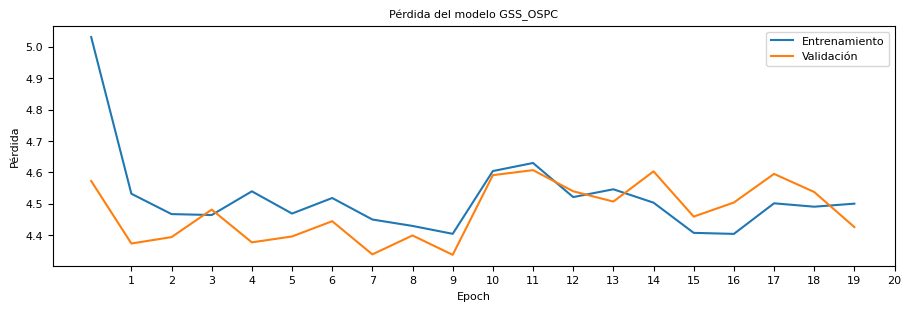

In [132]:
if DATASET == "OSPC":
    if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_GSS_OSPC, hist_model_GSS_OSPC, "OSPC")

In [133]:
def gss_st_greedy_decode(model : GSS_NMT, src, max_len, bos_symbol, pad_symbol, eos_symbol):  
    memory, memory_mask = model.encode(src)
    output = torch.ones(1, 1, device = GPU).fill_(bos_symbol).type(torch.long)
    for i in range(max_len-1):
        d_out  = model.decode(output, memory, memory_mask)
        logit = model.generator(d_out)       
        next_token = torch.argmax(logit[:, -1], dim=-1)  
        next_token = next_token.item()
        next_token = torch.ones(1, 1, device=GPU).type_as(src.data).fill_(next_token)
        output = torch.cat([output, next_token], dim = 1)
        if next_token == eos_symbol:
            break
    return output


In [134]:
if DATASET == "UNPC":
    if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_GSS_UNPC, unpc_tstset, DatasetScope.UN, gss_st_greedy_decode)

In [135]:
if DATASET == "OSPC":
    if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_GSS_OSPC, ospc_tstset, DatasetScope.OS, gss_st_greedy_decode)

In [136]:
if 5 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    del model_GSS_UNPC
    del model_GSS_OSPC

In [137]:
torch.cuda.mem_get_info()

(8423211008, 12884246528)

### **Modelo 6: Moving Average Equipped Gated Attention**

In [138]:
# https://arxiv.org/abs/2209.10655
# $pip install mega-pytorch

In [139]:

from mega_pytorch import MegaLayer

class MEGA_Encoder(nn.Module):
    def __init__(self, vocab_size,  d_model = 512, depth = 3, max_length = 128, dropout = 0.10, device = None):
        super().__init__()
        self.tok_emb = Embedder(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_length, dropout=dropout)       

        self.mha = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                MegaLayer(
                    dim = d_model,               # model dimensions
                    ema_heads = 16,              # number of EMA heads
                    attn_dim_qk = 64,            # dimension of queries / keys in attention
                    attn_dim_value = 256,        # dimension of values in attention
                    laplacian_attn_fn = False,   # whether to use softmax (false) or laplacian attention activation fn (true)
                )
                .cuda(),
                nn.LayerNorm(d_model),
                nn.Linear(d_model, 2 * d_model),
                nn.Linear(2 * d_model, d_model),
                nn.LayerNorm(d_model)
            ]))
        self.device = device

    def forward(self, x, mask):
        x = self.tok_emb(x)
        x = self.pos_emb(x)

        a = self.mha(query=x, key=x, value=x, mask=mask)
        x = self.mha_norm(x + self.dropout(a))
        
        r = x
        for mega, pre_norm, ffwd_1, ffwd_2, post_norm in self.layers:
            r = mega(r, r)
            r = pre_norm(r)

            residual = r

            r = ffwd_1(r)
            r = F.gelu(r)
            r = ffwd_2(r) + residual

            r = post_norm(r) 

        return r
    

class MEGA_Decoder(nn.Module):
    def __init__(self, vocab_size,  d_model = 512, depth = 3, max_length = UN_MAX_LEN, dropout = 0.10, device = None):
        super().__init__()
        self.tok_emb = Embedder(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_length, dropout=dropout) 

        self.mha_1 = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_2 = MultiHeadAttention(d_model, 8, dropout, device)
        self.mha_1_norm = nn.LayerNorm(d_model)
        self.mha_2_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                MegaLayer(
                    dim = d_model,               # model dimensions
                    ema_heads = 16,              # number of EMA heads
                    attn_dim_qk = 64,            # dimension of queries / keys in attention
                    attn_dim_value = 256,        # dimension of values in attention
                    laplacian_attn_fn = False,   # whether to use softmax (false) or laplacian attention activation fn (true)
                )
                .cuda(),
                nn.LayerNorm(d_model),
                nn.Linear(d_model, 2 * d_model),
                nn.Linear(2 * d_model, d_model),
                nn.LayerNorm(d_model)
            ]))
        self.device = device

    def forward(self, x, mask, context, context_mask): 
        x = self.tok_emb(x)
        x = self.pos_emb(x)

        # s-attn
        s = self.mha_1(query=x, key=x, value=x, mask=mask)
        x = self.mha_1_norm(x + self.dropout(s))

        # x-attn
        c = self.mha_2(query=x, key=context, value=context, mask=context_mask)
        x = self.mha_2_norm(x + self.dropout(c))

        r = x
        for mega, pre_norm, ffwd_1, ffwd_2, post_norm in self.layers:
            r = mega(r, r)
            r = pre_norm(r)

            residual = r

            r = ffwd_1(r)
            r = F.gelu(r)
            r = ffwd_2(r) + residual
            
            r = post_norm(r) 

        return r


class MEGA_NMT(NeuralMachineTranslator):
    def __init__(self, name, size_of_src_vocab, size_of_tgt_vocab,  d_model = 512, lr = TFMR_LR, max_seq_length = UN_MAX_LEN, device = None):
        super().__init__(name)      
        self.src_pad_idx = UNPC_PAD_EN_IDX
        self.trg_pad_idx = UNPC_PAD_ES_IDX
        self.encoder = MEGA_Encoder(size_of_src_vocab, d_model, max_length=max_seq_length, device=device)
        self.decoder = MEGA_Decoder(size_of_tgt_vocab, d_model, max_length=max_seq_length, device=device)
        self.generator = nn.Linear(d_model, size_of_tgt_vocab)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        self.device = device

    def make_src_mask(self, src):  # src: (bs, src_len)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask  # (bs, 1, 1, src_len)

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)  # (bs, 1, 1, trg_len)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()  # (trg_len, trg_len)
        trg_mask = trg_pad_mask & trg_sub_mask  # (bs, 1, trg_len, trg_len)
        return trg_mask


    def forward(self, src, tgt):
        s_mask = self.make_src_mask(src)
        t_mask = self.make_trg_mask(tgt)
        x = self.encoder(src, s_mask)
        x = self.decoder(tgt, t_mask, x, s_mask)
        x = self.generator(x)
        return x

    def encode(self, x):
        mask = self.make_src_mask(x)
        x = self.encoder(x, mask)
        return x, mask

    def decode(self, x, ctx, ctx_mask):
        mask = self.make_trg_mask(x)
        x = self.decoder(x, mask, ctx, ctx_mask) 
        return x

    def isBatchSizeFirst(self):
        return True

In [140]:
def train_routine_mega(model : MEGA_NMT, dataset, device, clip=None, gc_count = 2):
    """
    Rutina de entrenamiento para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de entrenamiento sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio por época.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a entrenar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').
        clip (float, opcional): Valor opcional para aplicar clipping del gradiente. Default es None.

    Returns:
        float: Pérdida promedio por época.
        float: Precisión multietiqueta promedio por época.
        float: Precisión de Hamming promedio por época.
        int: Número total de muestras procesadas en la época.
    """
    model.train()       
    epoch_loss = 0
    epoch_accm = 0
    epoch_wmem = 0
    epoch_lmem = 0 

    i = 0

    batches_before_gc = 0

    criterion = MaskedAccuracy(1, device)

    for _, _, _, src, tgt, _, _ in iter(dataset):      
      
        src = src.permute(1,0)
        tgt = tgt.permute(1,0)

        tgt_i ,  tgt_o = shift(tgt, True)

        epoch_wmem += getSizeOf(src)
        epoch_wmem += getSizeOf(tgt)

        logits = model(src, tgt_i)

        logits = logits.transpose(1, 2)

        epoch_lmem += getSizeOf(logits)

        loss = model.update(logits, tgt_o)   
        
        accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

        epoch_wmem += getSizeOf(loss)
        epoch_wmem += getSizeOf(accm)

        epoch_loss += loss 
        epoch_accm += accm     

        if i % 100 == 99:           
            now = datetime.datetime.now()
            time_str = now.strftime("%Y-%m-%d %H:%M:%S")
            print(' [{0}] - train - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

        i += 1

        del src
        del tgt
        del loss
        del accm
        del logits

        if torch.cuda.is_available():
            batches_before_gc += 1
            if (batches_before_gc > gc_count):
                torch.cuda.empty_cache()       
                batches_before_gc = 0
    trn_loss = (epoch_loss / i).item()   
    trn_accm = (epoch_accm / i).item() 
    
    trn_wrkmem = (epoch_wmem / i) 
    trn_logmem = (epoch_lmem / i) 

    return trn_loss, trn_accm, trn_wrkmem, trn_logmem


In [141]:
def eval_routine_mega(model : MEGA_NMT, dataset, device, gc_count = 2):
    """
    Rutina de evaluación para un modelo de clasificación multietiqueta.

    Esta función realiza un ciclo de evaluación sobre un conjunto de datos,
    calculando la pérdida promedio, precisión multietiqueta promedio y precisión
    de Hamming promedio.

    Args:
        model (MultiLabelClassifier): Modelo de clasificación multietiqueta a evaluar.
        dataset (iterable): Conjunto de datos iterable que proporciona inputs, etiquetas y longitudes.
        device (torch.device): Dispositivo de ejecución ('cpu' o 'cuda').

    Returns:
        float: Pérdida promedio en la evaluación.
        float: Precisión multietiqueta promedio en la evaluación.
        float: Precisión de Hamming promedio en la evaluación.
        int: Número total de muestras evaluadas.
    """
    model.eval()    
    epoch_loss = 0
    epoch_accm = 0 
    epoch_wmem = 0
    epoch_lmem = 0 
    with torch.no_grad():  

        criterion = MaskedAccuracy(1, device)
        batches_before_gc = 0

        i = 0

        for  _, _, _, src, tgt, _, _ in iter(dataset):

            src = src.permute(1,0)
            tgt = tgt.permute(1,0)

            tgt_i , tgt_o = shift(tgt, True)
            
            epoch_wmem += getSizeOf(src)
            epoch_wmem += getSizeOf(tgt)

            logits = model(src, tgt_i)
            logits = logits.transpose(1, 2)

            epoch_lmem += getSizeOf(logits)
       
            loss = model.Loss(logits, tgt_o)   
            
            accm = criterion(tgt_o, logits,  UNPC_PAD_ES_IDX)   

            epoch_loss += loss 
            epoch_accm += accm

            if i % 100 == 99: 
                now = datetime.datetime.now()
                time_str = now.strftime("%Y-%m-%d %H:%M:%S")
                print(' [{0}] - eval - batch {1} loss: {2} acc: {3}'.format(time_str, i + 1, epoch_loss.item() / (i + 1), epoch_accm.item() / (i + 1) ))

            epoch_wmem += getSizeOf(loss)
            epoch_wmem += getSizeOf(accm)

            i += 1

            del src
            del tgt
            del logits
            del loss
            del accm
            if torch.cuda.is_available():
                batches_before_gc += 1
                if (batches_before_gc > gc_count):
                    torch.cuda.empty_cache()       
                    batches_before_gc = 0

    val_loss = (epoch_loss / i).item()
    val_accm = (epoch_accm / i).item()
    val_wrkmem = epoch_wmem / i
    val_logmem = epoch_lmem / i
        
    return val_loss,  val_accm, val_wrkmem, val_logmem


In [142]:
if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_MEGA_UNPC = MEGA_NMT("MEGA_UNPC", unpc_en_vocab_size, unpc_es_vocab_size, max_seq_length=UN_MAX_LEN, device=GPU)
    model_MEGA_UNPC.apply(weights_init_with_xavier)
    model_MEGA_UNPC = model_MEGA_UNPC.to(GPU)
    torch.compile(model_MEGA_UNPC)

In [143]:
if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    seed_everything(seed=1234)
    model_MEGA_OSPC = MEGA_NMT("MEGA_OSPC", ospc_en_vocab_size, ospc_es_vocab_size, max_seq_length=OS_MAX_LEN, device=GPU)
    model_MEGA_OSPC.apply(weights_init_with_xavier)
    model_MEGA_OSPC = model_MEGA_OSPC.to(GPU)
    torch.compile(model_MEGA_OSPC)

In [144]:
if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_MEGA_UNPC)

Model 'MEGA_UNPC' has 188151849 trainable parameters.


In [145]:
if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    count_params(model_MEGA_OSPC)

Model 'MEGA_OSPC' has 148849158 trainable parameters.


In [146]:
if DATASET == "UNPC":
    if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_MEGA_UNPC = run_learning_cycle(model_MEGA_UNPC, mega_unpc_en_es_model_path, unpc_trnset, unpc_valset, 
                                                 fn_train=train_routine_mega, fn_eval=eval_routine_mega, max_epochs=NUMBER_OF_EPOCHS)


In [147]:
if DATASET == "OSPC":
    if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        hist_model_MEGA_OSPC = run_learning_cycle(model_MEGA_OSPC, mega_ospc_en_es_model_path, ospc_trnset, ospc_valset, 
                                                 fn_train=train_routine_mega, fn_eval=eval_routine_mega, max_epochs=NUMBER_OF_EPOCHS)


MEGA_OSPC
Continuando entrenamiento del modelo MEGA_OSPC desde el checkpoint en la época 21
- Época 1 logra T.Pérdida = 4.99581146 E.Pérdida = 4.35681868 y T.Acc = 0.29411724 E.Acc = 0.3632963 Tiempo = 7850.94469796 seg. 
- Época 2 logra T.Pérdida = 4.14867973 E.Pérdida = 3.90592074 y T.Acc = 0.38833457 E.Acc = 0.42376894 Tiempo = 8328.37544623 seg. 
- Época 3 logra T.Pérdida = 3.81747198 E.Pérdida = 3.70077729 y T.Acc = 0.43227422 E.Acc = 0.45283213 Tiempo = 8746.90708091 seg. 
- Época 4 logra T.Pérdida = 3.61437058 E.Pérdida = 3.5425508 y T.Acc = 0.45885429 E.Acc = 0.47162816 Tiempo = 8579.65054834 seg. 
- Época 5 logra T.Pérdida = 3.47300887 E.Pérdida = 3.44950986 y T.Acc = 0.47702837 E.Acc = 0.48470342 Tiempo = 8177.04491222 seg. 
- Época 6 logra T.Pérdida = 3.36907458 E.Pérdida = 3.37377572 y T.Acc = 0.49032384 E.Acc = 0.49444652 Tiempo = 8260.77977834 seg. 
- Época 7 logra T.Pérdida = 3.29019642 E.Pérdida = 3.32752371 y T.Acc = 0.50065112 E.Acc = 0.50235456 Tiempo = 7641.1738112 

In [148]:
if DATASET == "UNPC":
    if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_MEGA_UNPC, hist_model_MEGA_UNPC, "UNPC")

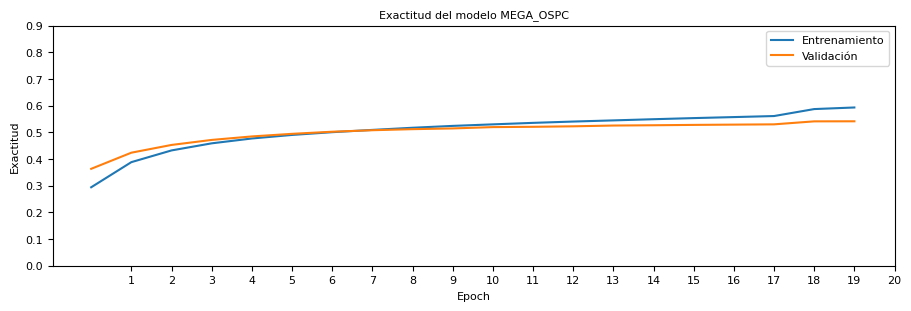

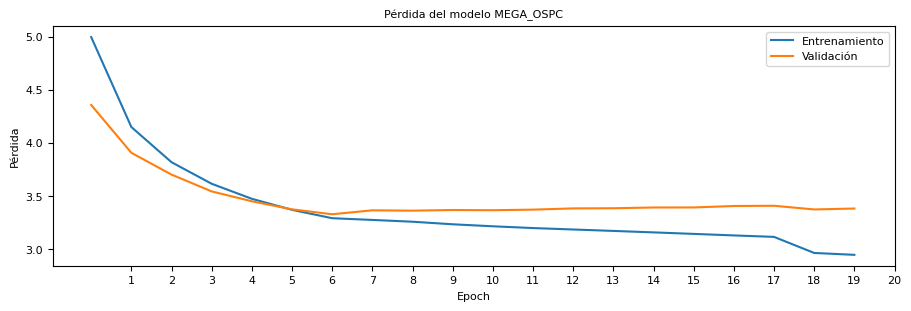

In [149]:
if DATASET == "OSPC":
    if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        evaluate_model_performance(model_MEGA_OSPC, hist_model_MEGA_OSPC, "OSPC")

In [150]:
def mega_st_greedy_decode(model : MEGA_NMT, src, max_len, bos_symbol, pad_symbol, eos_symbol):  
    memory, memory_mask = model.encode(src)
    output = torch.ones(1, 1, device = GPU).fill_(bos_symbol).type(torch.long)
    for i in range(max_len-1):
        d_out  = model.decode(output, memory, memory_mask)
        logit = model.generator(d_out)       
        next_token = torch.argmax(logit[:, -1], dim=-1)  
        next_token = next_token.item()
        next_token = torch.ones(1, 1, device=GPU).type_as(src.data).fill_(next_token)
        output = torch.cat([output, next_token], dim = 1)
        if next_token == eos_symbol:
            break
    return output


In [151]:
if DATASET == "UNPC":
    if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_MEGA_UNPC , unpc_tstset, DatasetScope.UN, function = mega_st_greedy_decode)

In [152]:
if DATASET == "OSPC":
    if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
        execute_model_inference(model_MEGA_OSPC, ospc_tstset, DatasetScope.OS, function = mega_st_greedy_decode)

In [153]:
if 6 in range(MIN_ALGO_NUMBER, MAX_ALGO_NUMBER+1): 
    del model_MEGA_UNPC
    del model_MEGA_OSPC

In [154]:
torch.cuda.mem_get_info()

(8557428736, 12884246528)

### Resumenes de resultados

In [155]:
result_LP = pd.concat(info_LP)
result_LP.to_csv("./LP.csv", sep=';', index=True, encoding='utf-8')
print(result_LP)

    Unnamed: 0     model_name  model_epoch model_lang  trn_loss  trn_accm  \
0            1  Vainilla_OSPC            1       OSPC    5.0053    0.2919   
1            2  Vainilla_OSPC            2       OSPC    4.1717    0.3791   
2            3  Vainilla_OSPC            3       OSPC    3.8821    0.4141   
3            4  Vainilla_OSPC            4       OSPC    3.7055    0.4354   
4            5  Vainilla_OSPC            5       OSPC    3.5785    0.4506   
..         ...            ...          ...        ...       ...       ...   
15          16      MEGA_OSPC           16       OSPC    3.1425    0.5535   
16          17      MEGA_OSPC           17       OSPC    3.1281    0.5573   
17          18      MEGA_OSPC           18       OSPC    3.1143    0.5612   
18          19      MEGA_OSPC           19       OSPC    2.9630    0.5873   
19          20      MEGA_OSPC           20       OSPC    2.9454    0.5933   

    trn_pplx  val_loss  val_accm  val_pplx  
0   149.1976    4.3120    0.36

In [156]:
result_PF = pd.concat(info_PF)
result_PF.to_csv("./PF.csv", sep=';', index=True, encoding='utf-8')
print(result_PF)

    Unnamed: 0     model_name  model_epoch model_lang  trn_wrkmem  trn_logmem  \
0            1  Vainilla_OSPC            1       OSPC      0.0311    531.7691   
1            2  Vainilla_OSPC            2       OSPC      0.0311    531.0739   
2            3  Vainilla_OSPC            3       OSPC      0.0311    531.9374   
3            4  Vainilla_OSPC            4       OSPC      0.0311    531.4155   
4            5  Vainilla_OSPC            5       OSPC      0.0311    530.7698   
..         ...            ...          ...        ...         ...         ...   
15          16      MEGA_OSPC           16       OSPC      0.0249    531.3593   
16          17      MEGA_OSPC           17       OSPC      0.0249    531.4142   
17          18      MEGA_OSPC           18       OSPC      0.0249    531.6456   
18          19      MEGA_OSPC           19       OSPC      0.0248    530.5109   
19          20      MEGA_OSPC           20       OSPC      0.0249    531.2395   

    trn_elapsed_time  val_w

In [157]:
# Se recolectan y consolidan los resultados en archivos para construir la PPT
results_for_st = pd.concat(st_metrics)
results_for_st.to_csv("./st_inference.csv", sep=';', index=True, encoding='utf-8')
print(results_for_st)

   Unnamed: 0     model_name model_lang      BLEU  inference_avg_time  \
0           1  Vainilla_OSPC         ES  0.493808            0.043030   
0           1        UT_OSPC         ES  0.484394            0.035898   
0           1       SSM_OSPC         ES  0.459680            0.019668   
0           1       MoE_OSPC         ES  0.495990            0.050629   
0           1       GSS_OSPC         ES  0.397642            0.032863   
0           1      MEGA_OSPC         ES  0.495972            0.063282   

   inference_ttl_time  
0         4253.495415  
0         3548.491521  
0         1944.204042  
0         5004.671196  
0         3248.458429  
0         6255.369137  


In [158]:
if (len(st_samples) > 0):
    samples_for_st = pd.concat(st_samples)
    samples_for_st.to_csv("./st_samples.csv", sep=';', index=True, encoding='utf-8')
    print(samples_for_st)

   Unnamed: 0 sample_index     model_name SRC_LNG  \
0           1     [945093]  Vainilla_OSPC      EN   
1           2     [351656]  Vainilla_OSPC      EN   
2           3     [999785]  Vainilla_OSPC      EN   
3           4     [282817]  Vainilla_OSPC      EN   
4           5     [766054]  Vainilla_OSPC      EN   
5           6     [575674]  Vainilla_OSPC      EN   
6           7     [535990]  Vainilla_OSPC      EN   
7           8      [21998]  Vainilla_OSPC      EN   
8           9     [944970]  Vainilla_OSPC      EN   
9          10     [926861]  Vainilla_OSPC      EN   
0           1     [945093]        UT_OSPC      EN   
1           2     [351656]        UT_OSPC      EN   
2           3     [999785]        UT_OSPC      EN   
3           4     [282817]        UT_OSPC      EN   
4           5     [766054]        UT_OSPC      EN   
5           6     [575674]        UT_OSPC      EN   
6           7     [535990]        UT_OSPC      EN   
7           8      [21998]        UT_OSPC     